In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import warnings

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fpt_data=pd.read_csv('/content/drive/MyDrive/Barefoots/Vòng 2/Code/Main/PreTrain Data/FPT raw.csv')
cmc_data=pd.read_csv('/content/drive/MyDrive/Barefoots/Vòng 2/Code/Main/PreTrain Data/CMC raw.csv')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

def preprocess_enhanced(df_train, df_test):
    """
    Enhanced preprocessing function to handle the additional volume data
    and create more sophisticated features.

    Parameters:
    - df_train: DataFrame with time, high, low, volume columns
    - df_test: DataFrame with time, high, low, volume columns

    Returns:
    - Processed DataFrames for training and testing
    """
    # Step 1: Combine train and test tables
    df_train['dataset'] = 'train'
    df_test['dataset'] = 'test'
    df_combined = pd.concat([df_train, df_test], axis=0)

    # Normalize volume by dividing by 1e6 as suggested
    if 'volume' in df_combined.columns:
        df_combined['volume'] = df_combined['volume'] / 1e6

    # Step 2: Filter out closed market days
    df_combined = df_combined.dropna(subset=['high', 'low'], how='all')

    # Step 3: Create target column
    df_combined['target'] = (df_combined['high'] + df_combined['low']) / 2

    # Step 4: Extract and encode cyclical time features
    df_combined['datetime'] = pd.to_datetime(df_combined['time'])

    # Cyclic encoding for month (1-12)
    df_combined['month'] = df_combined['datetime'].dt.month
    df_combined['month_sin'] = np.sin(2 * np.pi * df_combined['month'] / 12)
    df_combined['month_cos'] = np.cos(2 * np.pi * df_combined['month'] / 12)

    # Cyclic encoding for day of week (0-6)
    df_combined['day_of_week'] = df_combined['datetime'].dt.dayofweek
    df_combined['dow_sin'] = np.sin(2 * np.pi * df_combined['day_of_week'] / 7)
    df_combined['dow_cos'] = np.cos(2 * np.pi * df_combined['day_of_week'] / 7)

    # Cyclic encoding for day of month (1-31)
    df_combined['day'] = df_combined['datetime'].dt.day
    df_combined['day_sin'] = np.sin(2 * np.pi * df_combined['day'] / 31)
    df_combined['day_cos'] = np.cos(2 * np.pi * df_combined['day'] / 31)

    # Cyclic encoding for day of year (1-366)
    df_combined['day_of_year'] = df_combined['datetime'].dt.dayofyear
    df_combined['doy_sin'] = np.sin(2 * np.pi * df_combined['day_of_year'] / 366)
    df_combined['doy_cos'] = np.cos(2 * np.pi * df_combined['day_of_year'] / 366)

    # Step 5: Set time as index
    df_combined = df_combined.set_index('time')
    df_combined.drop(['datetime', 'month', 'day_of_week', 'day', 'day_of_year'], axis=1, inplace=True)

    # Step 6: Create lag features for target and volume
    lag_values = [1, 2, 3, 5, 7, 10, 14, 21, 30, 45, 60, 90]
    for lag in lag_values:
        df_combined[f'target_lag_{lag}'] = df_combined['target'].shift(lag)

        # Add volume lag features if volume data exists
        if 'volume' in df_combined.columns:
            df_combined[f'volume_lag_{lag}'] = df_combined['volume'].shift(lag)

    # Step 7: Create statistical features from lagged values
    window_sizes = [5, 10, 20, 30, 60]
    for window in window_sizes:
        # Moving average
        df_combined[f'target_ma_{window}'] = df_combined['target'].rolling(window=window, min_periods=1).mean()

        # Moving standard deviation
        df_combined[f'target_std_{window}'] = df_combined['target'].rolling(window=window, min_periods=2).std()

        # Exponentially weighted moving average
        df_combined[f'target_ema_{window}'] = df_combined['target'].ewm(span=window, min_periods=1).mean()

        # Add volume-based features if volume exists
        if 'volume' in df_combined.columns:
            df_combined[f'volume_ma_{window}'] = df_combined['volume'].rolling(window=window, min_periods=1).mean()
            df_combined[f'volume_std_{window}'] = df_combined['volume'].rolling(window=window, min_periods=2).std()
            df_combined[f'volume_ema_{window}'] = df_combined['volume'].ewm(span=window, min_periods=1).mean()

            # Volume-price ratio
            df_combined[f'volume_price_ratio_{window}'] = df_combined['volume'] / df_combined[f'target_ma_{window}']

    # Step 8: Create price volatility features
    for period in [1, 3, 5, 7, 14, 21]:
        df_combined[f'price_change_{period}d'] = df_combined['target'].diff(period)
        df_combined[f'pct_change_{period}d'] = df_combined['target'].pct_change(period) * 100

        # Add volume change features if volume exists
        if 'volume' in df_combined.columns:
            df_combined[f'volume_change_{period}d'] = df_combined['volume'].diff(period)
            df_combined[f'volume_pct_change_{period}d'] = df_combined['volume'].pct_change(period) * 100

    # Step 9: Create volatility features
    for window in [7, 14, 30]:
        # Volatility (based on standard deviation of % change)
        df_combined[f'volatility_{window}d'] = df_combined['pct_change_1d'].rolling(window=window).std()

        # Add volume volatility if volume exists
        if 'volume' in df_combined.columns:
            vol_change_col = 'volume_pct_change_1d'
            if vol_change_col in df_combined.columns:
                df_combined[f'volume_volatility_{window}d'] = df_combined[vol_change_col].rolling(window=window).std()

    # Step 10: Create momentum features
    for window in [5, 10, 20, 30]:
        # Rate of Change (ROC)
        df_combined[f'roc_{window}'] = (df_combined['target'] / df_combined['target'].shift(window) - 1) * 100

        # Relative Strength Index (RSI)
        delta = df_combined['target'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=window, min_periods=1).mean()
        avg_loss = loss.rolling(window=window, min_periods=1).mean()
        rs = avg_gain / avg_loss.replace(0, np.nan)
        df_combined[f'rsi_{window}'] = 100 - (100 / (1 + rs))

    # Step 11: Create price range features
    df_combined['high_low_range'] = df_combined['high'] - df_combined['low']
    df_combined['high_low_range_pct'] = df_combined['high_low_range'] / df_combined['target'] * 100

    # Step 12: Create trend features
    df_combined['trend'] = np.sign(df_combined['price_change_1d'])

    # Duration of continuous trend
    df_combined['trend_duration'] = 0
    trend = 0
    prev_trend = 0
    for i in range(len(df_combined)):
        current_trend = df_combined['trend'].iloc[i]
        if pd.isna(current_trend):
            trend = 0
        elif current_trend == prev_trend:
            trend += 1
        else:
            trend = 1
        df_combined.loc[df_combined.index[i], 'trend_duration'] = trend
        prev_trend = current_trend if not pd.isna(current_trend) else 0

    # Add volume-price relationship features
    if 'volume' in df_combined.columns:
        # On-Balance Volume (OBV)
        df_combined['obv'] = 0
        obv_value = 0

        for i in range(1, len(df_combined)):
            if df_combined['target'].iloc[i] > df_combined['target'].iloc[i-1]:
                obv_value += df_combined['volume'].iloc[i]
            elif df_combined['target'].iloc[i] < df_combined['target'].iloc[i-1]:
                obv_value -= df_combined['volume'].iloc[i]
            df_combined.iloc[i, df_combined.columns.get_loc('obv')] = obv_value

        # Calculate OBV moving average
        for window in [5, 10, 20]:
            df_combined[f'obv_ma_{window}'] = df_combined['obv'].rolling(window=window).mean()

        # Chaikin Money Flow (CMF)
        for window in [10, 20]:
            mf_multiplier = ((df_combined['target'] - df_combined['low']) -
                             (df_combined['high'] - df_combined['target'])) / df_combined['high_low_range']
            money_flow_volume = mf_multiplier * df_combined['volume']
            df_combined[f'cmf_{window}'] = (money_flow_volume.rolling(window).sum() /
                                          df_combined['volume'].rolling(window).sum())

    # Add Bollinger Bands
    for window in [20]:
        # Calculate middle band (SMA)
        df_combined[f'bb_middle_{window}'] = df_combined['target'].rolling(window=window).mean()
        # Calculate standard deviation
        df_combined[f'bb_std_{window}'] = df_combined['target'].rolling(window=window).std()
        # Calculate upper and lower bands
        df_combined[f'bb_upper_{window}'] = df_combined[f'bb_middle_{window}'] + 2 * df_combined[f'bb_std_{window}']
        df_combined[f'bb_lower_{window}'] = df_combined[f'bb_middle_{window}'] - 2 * df_combined[f'bb_std_{window}']
        # Calculate bandwidth
        df_combined[f'bb_bandwidth_{window}'] = (df_combined[f'bb_upper_{window}'] - df_combined[f'bb_lower_{window}']) / df_combined[f'bb_middle_{window}']
        # Calculate B percentage
        df_combined[f'bb_b_{window}'] = (df_combined['target'] - df_combined[f'bb_lower_{window}']) / (df_combined[f'bb_upper_{window}'] - df_combined[f'bb_lower_{window}'])

    # Add MACD
    fast_window, slow_window, signal_window = 12, 26, 9
    df_combined['macd_fast'] = df_combined['target'].ewm(span=fast_window, min_periods=fast_window).mean()
    df_combined['macd_slow'] = df_combined['target'].ewm(span=slow_window, min_periods=slow_window).mean()
    df_combined['macd'] = df_combined['macd_fast'] - df_combined['macd_slow']
    df_combined['macd_signal'] = df_combined['macd'].ewm(span=signal_window, min_periods=signal_window).mean()
    df_combined['macd_hist'] = df_combined['macd'] - df_combined['macd_signal']

    # Step 13: Split back into train and test sets
    df_train_processed = df_combined[df_combined['dataset'] == 'train'].drop('dataset', axis=1)
    df_test_processed = df_combined[df_combined['dataset'] == 'test'].drop('dataset', axis=1)

    # Step 14: Drop rows with NaN for training set
    df_train_processed = df_train_processed.dropna()

    # Step 15: Reset indices for both sets
    df_train_processed = df_train_processed.reset_index(drop=True)
    df_test_processed = df_test_processed.reset_index(drop=True)

    return df_train_processed, df_test_processed

def define_price_movements(df, threshold_pct=1.5, days_ahead=1, method='any'):
    """
    Define days with strong price movements according to multiple criteria.

    Parameters:
    - df: DataFrame containing price data (target, high, low)
    - threshold_pct: % change to consider as strong movement (default 1.5%)
    - days_ahead: Number of future days to consider for movement (default 1 day)
    - method: Method to determine strong movement ('any', 'range', 'close', 'gap')

    Returns:
    - DataFrame with new columns marking strong movements
    """
    result_df = df.copy()

    # 1. Calculate percentage changes between days
    # Close price change
    result_df['price_change_pct'] = result_df['target'].pct_change(days_ahead) * 100
    result_df['abs_price_change_pct'] = result_df['price_change_pct'].abs()

    # Range volatility (high - low)
    result_df['high_low_range'] = result_df['high'] - result_df['low']
    result_df['high_low_range_pct'] = result_df['high_low_range'] / result_df['target'] * 100

    # Gap volatility (gap between days)
    result_df['gap_pct'] = (result_df['target'] - result_df['target'].shift(1)) / result_df['target'].shift(1) * 100
    result_df['abs_gap_pct'] = result_df['gap_pct'].abs()

    # Calculate volatility over window
    result_df['volatility_10d'] = result_df['target'].pct_change().rolling(10).std() * 100 * np.sqrt(10)

    # 2. Set threshold for marking strong movements
    # Fixed threshold from parameter
    fixed_threshold = threshold_pct

    # Dynamic threshold based on distribution (e.g., above 90th percentile)
    dynamic_threshold = result_df['abs_price_change_pct'].quantile(0.9)

    # Use appropriate threshold (prioritize fixed if provided)
    final_threshold = fixed_threshold if fixed_threshold is not None else dynamic_threshold

    # 3. Mark strong movements according to different criteria

    # Strong movement by close price
    result_df['strong_move_close'] = result_df['abs_price_change_pct'] > final_threshold

    # Strong movement by daily range
    result_df['strong_move_range'] = result_df['high_low_range_pct'] > final_threshold * 1.5

    # Strong movement by gap
    result_df['strong_move_gap'] = result_df['abs_gap_pct'] > final_threshold

    # Strong movement by direction (up/down)
    result_df['up_move'] = (result_df['price_change_pct'] > final_threshold)
    result_df['down_move'] = (result_df['price_change_pct'] < -final_threshold)

    # 4. Mark strong movement by chosen method
    if method == 'any':
        # Strong movement if meets any criteria
        result_df['large_movement'] = (
            result_df['strong_move_close'] |
            result_df['strong_move_range'] |
            result_df['strong_move_gap']
        )
    elif method == 'range':
        # Only based on daily range
        result_df['large_movement'] = result_df['strong_move_range']
    elif method == 'close':
        # Only based on close price change
        result_df['large_movement'] = result_df['strong_move_close']
    elif method == 'gap':
        # Only based on gap
        result_df['large_movement'] = result_df['strong_move_gap']
    else:
        # Default: based on close price change
        result_df['large_movement'] = result_df['strong_move_close']

    # 5. Prediction for future: Mark current days that have strong movement X days ahead
    for i in range(1, days_ahead + 1):
        # Shift large_movement label back i days
        # (day t is marked if day t+i has strong movement)
        result_df[f'large_movement_{i}d_ahead'] = result_df['large_movement'].shift(-i)
        result_df[f'up_move_{i}d_ahead'] = result_df['up_move'].shift(-i)
        result_df[f'down_move_{i}d_ahead'] = result_df['down_move'].shift(-i)

    # Create combined target: strong movement in next X days
    future_cols = [f'large_movement_{i}d_ahead' for i in range(1, days_ahead + 1)]
    result_df['large_movement_in_future'] = result_df[future_cols].any(axis=1)

    # Same for direction
    future_up_cols = [f'up_move_{i}d_ahead' for i in range(1, days_ahead + 1)]
    future_down_cols = [f'down_move_{i}d_ahead' for i in range(1, days_ahead + 1)]
    result_df['up_move_in_future'] = result_df[future_up_cols].any(axis=1)
    result_df['down_move_in_future'] = result_df[future_down_cols].any(axis=1)

    # Columns to clean NaN values
    cols_to_clean = ['large_movement', 'large_movement_in_future', 'up_move_in_future', 'down_move_in_future']
    cols_to_clean.extend(future_cols)
    cols_to_clean.extend(future_up_cols)
    cols_to_clean.extend(future_down_cols)

    # Convert NaN to False
    for col in cols_to_clean:
        if col in result_df.columns:
            result_df[col] = result_df[col].fillna(False)

    return result_df

def prepare_movement_features(df, window_size=20):
    """
    Create features focused on predicting price movements.

    Parameters:
    - df: DataFrame with labeled price movements
    - window_size: Size of window for feature calculation

    Returns:
    - X: Features DataFrame
    - y: Target DataFrame
    - price_cols: Original price columns
    - df_features: Complete features DataFrame
    """
    df_features = df.copy()

    # 1. Basic price features
    df_features['hl_range'] = df_features['high'] - df_features['low']
    df_features['hl_range_pct'] = df_features['hl_range'] / df_features['target'] * 100

    # 2. Candlestick pattern features
    # Body size
    df_features['body_size'] = (df_features['target'] - df_features['target'].shift(1)).abs()
    df_features['body_size_pct'] = df_features['body_size'] / df_features['target'].shift(1) * 100

    # Shadow sizes
    df_features['upper_shadow'] = df_features['high'] - df_features['target'].clip(lower=df_features['target'].shift(1))
    df_features['lower_shadow'] = df_features['target'].clip(upper=df_features['target'].shift(1)) - df_features['low']
    df_features['upper_shadow_pct'] = df_features['upper_shadow'] / df_features['target'] * 100
    df_features['lower_shadow_pct'] = df_features['lower_shadow'] / df_features['target'] * 100

    # Candlestick patterns
    df_features['doji'] = df_features['body_size_pct'] < 0.1
    df_features['marubozu'] = (df_features['body_size_pct'] > 0.7) & (df_features['upper_shadow_pct'] < 0.1) & (df_features['lower_shadow_pct'] < 0.1)
    df_features['hammer'] = (df_features['lower_shadow_pct'] > 2 * df_features['body_size_pct']) & (df_features['upper_shadow_pct'] < 0.5)
    df_features['shooting_star'] = (df_features['upper_shadow_pct'] > 2 * df_features['body_size_pct']) & (df_features['lower_shadow_pct'] < 0.5)

    # 3. Price movement and trend features
    # Price changes over multiple timeframes
    for period in [1, 2, 3, 5, 10, 20]:
        df_features[f'change_{period}d'] = df_features['target'].pct_change(periods=period) * 100
        df_features[f'close_to_high_{period}d'] = (df_features['target'] / df_features['high'].rolling(period).max() - 1) * 100
        df_features[f'close_to_low_{period}d'] = (df_features['target'] / df_features['low'].rolling(period).min() - 1) * 100

        # Add volume features if available
        if 'volume' in df_features.columns:
            df_features[f'vol_change_{period}d'] = df_features['volume'].pct_change(periods=period) * 100
            # Volume delta vs price delta correlation
            price_change = df_features['target'].pct_change(periods=period)
            volume_change = df_features['volume'].pct_change(periods=period)
            df_features[f'price_vol_corr_{period}d'] = np.sign(price_change) == np.sign(volume_change)

    # Momentum and trend indicators
    for window in [5, 10, 20]:
        # Rate of change
        df_features[f'roc_{window}'] = (df_features['target'] / df_features['target'].shift(window) - 1) * 100

        # Moving averages
        df_features[f'sma_{window}'] = df_features['target'].rolling(window=window).mean()
        df_features[f'ema_{window}'] = df_features['target'].ewm(span=window, adjust=False).mean()

        # Trend indicators
        df_features[f'above_sma_{window}'] = (df_features['target'] > df_features[f'sma_{window}']).astype(int)
        df_features[f'above_ema_{window}'] = (df_features['target'] > df_features[f'ema_{window}']).astype(int)

        # Trend direction
        df_features[f'trend_{window}'] = df_features[f'sma_{window}'].diff(3).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

        # Volatility
        df_features[f'volatility_{window}'] = df_features['target'].pct_change().rolling(window).std() * 100 * np.sqrt(252/window)
        df_features[f'volatility_ratio_{window}'] = df_features[f'volatility_{window}'] / df_features[f'volatility_{window}'].rolling(window*3).mean()

        # High-Low range
        df_features[f'hl_range_{window}'] = df_features['hl_range'].rolling(window).mean()
        df_features[f'hl_range_ratio_{window}'] = df_features['hl_range'] / df_features[f'hl_range_{window}']

        # Volume features if available
        if 'volume' in df_features.columns:
            df_features[f'rel_volume_{window}'] = df_features['volume'] / df_features['volume'].rolling(window).mean()
            df_features[f'volume_trend_{window}'] = df_features['volume'].diff(window).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
            # Volume with price divergence
            price_trend = df_features['target'].diff(window).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
            volume_trend = df_features['volume'].diff(window).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
            df_features[f'price_vol_divergence_{window}'] = (price_trend != volume_trend).astype(int)

    # 4. Technical indicator features
    # RSI
    for window in [7, 14, 21]:
        # RSI calculation
        delta = df_features['target'].diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)

        avg_gain = gain.rolling(window=window, min_periods=1).mean()
        avg_loss = loss.rolling(window=window, min_periods=1).mean()

        rs = avg_gain / avg_loss.replace(0, 0.001)
        df_features[f'rsi_{window}'] = 100 - (100 / (1 + rs))

        # RSI conditions
        df_features[f'rsi_{window}_overbought'] = (df_features[f'rsi_{window}'] > 70).astype(int)
        df_features[f'rsi_{window}_oversold'] = (df_features[f'rsi_{window}'] < 30).astype(int)

        # RSI divergence
        price_direction = df_features['target'].diff(5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
        rsi_direction = df_features[f'rsi_{window}'].diff(5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
        df_features[f'rsi_{window}_divergence'] = (price_direction != rsi_direction).astype(int)

    # 5. Strong movement detection features
    # Bollinger Bands
    for window in [10, 20, 50]:
        rolling_mean = df_features['target'].rolling(window=window).mean()
        rolling_std = df_features['target'].rolling(window=window).std()

        df_features[f'bb_upper_{window}'] = rolling_mean + 2 * rolling_std
        df_features[f'bb_lower_{window}'] = rolling_mean - 2 * rolling_std
        df_features[f'bb_width_{window}'] = (df_features[f'bb_upper_{window}'] - df_features[f'bb_lower_{window}']) / rolling_mean * 100
        df_features[f'bb_pct_{window}'] = (df_features['target'] - df_features[f'bb_lower_{window}']) / (df_features[f'bb_upper_{window}'] - df_features[f'bb_lower_{window}'])

        # Bollinger Band Squeeze (when bands narrow - signals potential strong move)
        df_features[f'bb_squeeze_{window}'] = df_features[f'bb_width_{window}'] < df_features[f'bb_width_{window}'].rolling(window=window*2).quantile(0.2)

        # Bollinger Band Break (when price breaks bands - signals strong move happening)
        df_features[f'bb_break_upper_{window}'] = (df_features['target'] > df_features[f'bb_upper_{window}']).astype(int)
        df_features[f'bb_break_lower_{window}'] = (df_features['target'] < df_features[f'bb_lower_{window}']).astype(int)

    # Chaikin Volatility
    for window in [10, 20]:
        df_features[f'chaikin_vol_{window}'] = (df_features['hl_range'].rolling(window).mean() /
                                              df_features['hl_range'].rolling(window).mean().shift(window) - 1) * 100

    # 6. Count recent strong movements
    # Number of days with movement > X% in recent Y days
    thresholds = [0.5, 1.0, 1.5, 2.0]
    lookbacks = [5, 10, 20]

    for thresh in thresholds:
        daily_pct_change = df_features['target'].pct_change().abs() * 100
        is_large_move = (daily_pct_change > thresh).astype(int)

        for lookback in lookbacks:
            df_features[f'large_move_{thresh}pct_{lookback}d'] = is_large_move.rolling(lookback).sum()

            # Ratio of days with large moves
            df_features[f'large_move_ratio_{thresh}pct_{lookback}d'] = is_large_move.rolling(lookback).mean()

    # 7. Reversal point detection
    # Identify local peaks/valleys
    window = 5  # Window for determining extrema

    # Local peak
    df_features['local_peak'] = ((df_features['target'] > df_features['target'].shift(window)) &
                                (df_features['target'] > df_features['target'].shift(-window))).astype(int)

    # Local valley
    df_features['local_valley'] = ((df_features['target'] < df_features['target'].shift(window)) &
                                  (df_features['target'] < df_features['target'].shift(-window))).astype(int)

    # 8. Technical pattern features
    # Reversal patterns
    df_features['price_direction'] = np.sign(df_features['target'].diff())
    df_features['reversal'] = (df_features['price_direction'] != df_features['price_direction'].shift(1)).astype(int)

    # Breakout patterns
    for window in [10, 20, 50]:
        # Resistance and support
        resistance = df_features['high'].rolling(window=window).max()
        support = df_features['low'].rolling(window=window).min()

        # Identify breakouts
        df_features[f'breakout_up_{window}'] = (df_features['target'] > resistance.shift(1)).astype(int)
        df_features[f'breakout_down_{window}'] = (df_features['target'] < support.shift(1)).astype(int)

        # Distance to resistance/support
        df_features[f'pct_to_resistance_{window}'] = (resistance - df_features['target']) / df_features['target'] * 100
        df_features[f'pct_to_support_{window}'] = (df_features['target'] - support) / df_features['target'] * 100

    # 9. Handle NaN values
    df_features = df_features.replace([np.inf, -np.inf], np.nan)
    df_features = df_features.fillna(method='ffill').fillna(method='bfill').fillna(0)

    # 10. Split features and targets
    target_cols = ['large_movement', 'large_movement_in_future', 'up_move_in_future', 'down_move_in_future']
    target_cols.extend([col for col in df_features.columns if col.startswith('large_movement_') and col.endswith('d_ahead')])
    target_cols.extend([col for col in df_features.columns if col.startswith('up_move_') and col.endswith('d_ahead')])
    target_cols.extend([col for col in df_features.columns if col.startswith('down_move_') and col.endswith('d_ahead')])

    # Filter only target columns present in DataFrame
    available_targets = [col for col in target_cols if col in df_features.columns]

    # Split target columns
    price_cols = ['target', 'high', 'low']
    if 'volume' in df_features.columns:
        price_cols.append('volume')

    X = df_features.drop(available_targets + price_cols, axis=1)

    return X, df_features[available_targets], df_features[price_cols], df_features

def train_ensemble_models(X_train, y_train, days_ahead=1, class_weight=None):
    """
    Train ensemble models for price movement prediction, combining XGBoost and Random Forest.

    Parameters:
    - X_train: Training features
    - y_train: Training labels (DataFrame with multiple target columns)
    - days_ahead: Number of days in future to predict
    - class_weight: Weight for classes (to handle imbalance)

    Returns:
    - Dictionary containing trained models
    """
    models = {}

    # Identify target columns to predict
    if f'large_movement_{days_ahead}d_ahead' in y_train.columns:
        target_movement = f'large_movement_{days_ahead}d_ahead'
    else:
        target_movement = 'large_movement_in_future'

    if f'up_move_{days_ahead}d_ahead' in y_train.columns:
        target_up = f'up_move_{days_ahead}d_ahead'
    else:
        target_up = 'up_move_in_future'

    if f'down_move_{days_ahead}d_ahead' in y_train.columns:
        target_down = f'down_move_{days_ahead}d_ahead'
    else:
        target_down = 'down_move_in_future'

    # If class_weight is None, calculate automatically
    if class_weight is None:
        # Calculate positive/negative ratio
        pos_ratio = y_train[target_movement].mean()
        neg_ratio = 1 - pos_ratio

        # Assign weights inversely proportional to ratio
        if pos_ratio > 0 and neg_ratio > 0:
            class_weight = {0: 1/neg_ratio, 1: 1/pos_ratio}
            # Normalize so average weight = 1
            weight_sum = class_weight[0] * neg_ratio + class_weight[1] * pos_ratio
            class_weight = {0: class_weight[0]/weight_sum, 1: class_weight[1]/weight_sum}
        else:
            class_weight = {0: 1, 1: 1}

    # Print training information
    print(f"Training ensemble model for strong movements {days_ahead} days ahead:")
    print(f"  - Target: {target_movement}")
    print(f"  - Strong movement ratio: {y_train[target_movement].mean()*100:.2f}%")
    print(f"  - Class weights: {class_weight}")

    # Configure base models for ensemble

    # XGBoost configuration
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 5,
        'learning_rate': 0.05,
        'n_estimators': 200,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 3,
        'gamma': 0.1,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'random_state': 42,
        'scale_pos_weight': class_weight[1] / class_weight[0]
    }

    # Random Forest configuration
    rf_params = {
        'n_estimators': 100,
        'max_depth': 8,
        'min_samples_split': 10,
        'min_samples_leaf': 4,
        'max_features': 'sqrt',
        'random_state': 42,
        'class_weight': 'balanced' if class_weight is None else {0: class_weight[0], 1: class_weight[1]}
    }

    # Train movement prediction models (any strong movement)
    print(f"Training ensemble model for any strong movement...")

    # Base models for ensemble
    xgb_movement = xgb.XGBClassifier(**xgb_params)
    rf_movement = RandomForestClassifier(**rf_params)

    # Create VotingClassifier ensemble
    ensemble_movement = VotingClassifier(
        estimators=[
            ('xgb', xgb_movement),
            ('rf', rf_movement)
        ],
        voting='soft',  # Use probabilities for voting
        weights=[0.6, 0.4]  # Give slightly more weight to XGBoost
    )

    # Fit ensemble model
    ensemble_movement.fit(X_train, y_train[target_movement])
    models['movement'] = ensemble_movement

    # Train upward movement model
    print(f"Training ensemble model for upward movement...")
    xgb_up = xgb.XGBClassifier(**xgb_params)
    rf_up = RandomForestClassifier(**rf_params)

    ensemble_up = VotingClassifier(
        estimators=[
            ('xgb', xgb_up),
            ('rf', rf_up)
        ],
        voting='soft',
        weights=[0.6, 0.4]
    )

    ensemble_up.fit(X_train, y_train[target_up])
    models['up'] = ensemble_up

    # Train downward movement model
    print(f"Training ensemble model for downward movement...")
    xgb_down = xgb.XGBClassifier(**xgb_params)
    rf_down = RandomForestClassifier(**rf_params)

    ensemble_down = VotingClassifier(
        estimators=[
            ('xgb', xgb_down),
            ('rf', rf_down)
        ],
        voting='soft',
        weights=[0.6, 0.4]
    )

    ensemble_down.fit(X_train, y_train[target_down])
    models['down'] = ensemble_down

    # Store target information
    models['target_info'] = {
        'days_ahead': days_ahead,
        'movement_col': target_movement,
        'up_col': target_up,
        'down_col': target_down
    }

    # Extract feature importance if possible
    if hasattr(ensemble_movement, 'estimators_'):
        try:
            xgb_model = ensemble_movement.estimators_[0]
            rf_model = ensemble_movement.estimators_[1]

            # Get feature importances from both models
            xgb_importances = xgb_model.feature_importances_
            rf_importances = rf_model.feature_importances_

            # Combine importances with weighted average
            combined_importances = 0.6 * xgb_importances + 0.4 * rf_importances

            feature_importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': combined_importances
            }).sort_values('importance', ascending=False)

            models['feature_importance'] = feature_importance
        except:
            print("Could not extract feature importances from ensemble")

    return models

def predict_price_movements(models, X_test):
    """
    Predict probabilities of strong price movements.

    Parameters:
    - models: Dictionary containing trained models
    - X_test: Test features

    Returns:
    - DataFrame containing movement probabilities
    """
    # Check for required models
    required_models = ['movement', 'up', 'down']
    for model_name in required_models:
        if model_name not in models:
            raise ValueError(f"Missing model {model_name}")

    # Predict probabilities
    movement_probs = models['movement'].predict_proba(X_test)[:, 1]
    up_probs = models['up'].predict_proba(X_test)[:, 1]
    down_probs = models['down'].predict_proba(X_test)[:, 1]

    # Predict labels
    movement_preds = (movement_probs >= 0.5).astype(int)
    up_preds = (up_probs >= 0.5).astype(int)
    down_preds = (down_probs >= 0.5).astype(int)

    # Create results DataFrame
    days_ahead = models['target_info']['days_ahead']
    results = pd.DataFrame({
        f'prob_movement_{days_ahead}d': movement_probs,
        f'prob_up_{days_ahead}d': up_probs,
        f'prob_down_{days_ahead}d': down_probs,
        f'pred_movement_{days_ahead}d': movement_preds,
        f'pred_up_{days_ahead}d': up_preds,
        f'pred_down_{days_ahead}d': down_preds
    })

    # Predicted direction (1: up, -1: down, 0: no strong movement)
    results[f'pred_direction_{days_ahead}d'] = np.select(
        [
            (results[f'pred_up_{days_ahead}d'] == 1) & (results[f'pred_down_{days_ahead}d'] == 0),
            (results[f'pred_down_{days_ahead}d'] == 1) & (results[f'pred_up_{days_ahead}d'] == 0),
            (results[f'pred_up_{days_ahead}d'] == 1) & (results[f'pred_down_{days_ahead}d'] == 1)
        ],
        [1, -1, 0],
        default=0
    )

    # Evaluate prediction confidence
    conditions = [
        # High probability (> 0.7) for one direction, low probability (< 0.3) for other
        (results[f'prob_up_{days_ahead}d'] > 0.7) & (results[f'prob_down_{days_ahead}d'] < 0.3),
        (results[f'prob_down_{days_ahead}d'] > 0.7) & (results[f'prob_up_{days_ahead}d'] < 0.3),
        # High probability of strong movement (> 0.8)
        (results[f'prob_movement_{days_ahead}d'] > 0.8),
        # Medium probability of strong movement (> 0.6)
        (results[f'prob_movement_{days_ahead}d'] > 0.6),
        # Low probability of strong movement (< 0.4)
        (results[f'prob_movement_{days_ahead}d'] < 0.4)
    ]

    choices = ['Very high', 'Very high', 'High', 'Medium', 'Low']
    results[f'confidence_{days_ahead}d'] = np.select(conditions, choices, default='Medium')

    return results

def evaluate_movement_predictions(y_true, predictions, days_ahead=1):
    """
    Evaluate performance of movement prediction models.

    Parameters:
    - y_true: True labels
    - predictions: Predicted probabilities and labels
    - days_ahead: Number of days in future being predicted

    Returns:
    - Dictionary containing evaluation metrics
    """
    # Identify required columns
    if f'large_movement_{days_ahead}d_ahead' in y_true.columns:
        true_movement = y_true[f'large_movement_{days_ahead}d_ahead']
    else:
        true_movement = y_true['large_movement_in_future']

    if f'up_move_{days_ahead}d_ahead' in y_true.columns:
        true_up = y_true[f'up_move_{days_ahead}d_ahead']
    else:
        true_up = y_true['up_move_in_future']

    if f'down_move_{days_ahead}d_ahead' in y_true.columns:
        true_down = y_true[f'down_move_{days_ahead}d_ahead']
    else:
        true_down = y_true['down_move_in_future']

    # Identify prediction columns
    pred_movement_prob = predictions[f'prob_movement_{days_ahead}d']
    pred_up_prob = predictions[f'prob_up_{days_ahead}d']
    pred_down_prob = predictions[f'prob_down_{days_ahead}d']

    pred_movement = predictions[f'pred_movement_{days_ahead}d']
    pred_up = predictions[f'pred_up_{days_ahead}d']
    pred_down = predictions[f'pred_down_{days_ahead}d']

    # Report results
    print(f"\nEvaluating movement predictions {days_ahead} days ahead:")
    print("1. Strong movement prediction (any direction):")

    # Calculate metrics
    try:
        accuracy = accuracy_score(true_movement, pred_movement)
        precision = precision_score(true_movement, pred_movement)
        recall = recall_score(true_movement, pred_movement)
        f1 = f1_score(true_movement, pred_movement)
        roc_auc = roc_auc_score(true_movement, pred_movement_prob)

        # Calculate average precision (PR AUC)
        avg_precision = average_precision_score(true_movement, pred_movement_prob)

        print(f"  - Accuracy: {accuracy:.4f}")
        print(f"  - Precision: {precision:.4f} (Ratio of correct strong movement predictions)")
        print(f"  - Recall: {recall:.4f} (Ratio of strong movements detected)")
        print(f"  - F1 Score: {f1:.4f}")
        print(f"  - ROC AUC: {roc_auc:.4f}")
        print(f"  - PR AUC: {avg_precision:.4f}")

        # Print confusion matrix
        cm = confusion_matrix(true_movement, pred_movement)
        print("  - Confusion Matrix:")
        print(f"    TN: {cm[0, 0]}, FP: {cm[0, 1]}")
        print(f"    FN: {cm[1, 0]}, TP: {cm[1, 1]}")

        # Strong movement ratio
        print(f"  - Actual strong movement ratio: {true_movement.mean()*100:.2f}%")
        print(f"  - Predicted strong movement ratio: {pred_movement.mean()*100:.2f}%")
    except Exception as e:
        print(f"  Error in evaluation: {e}")

    # Evaluate direction predictions
    try:
        print("\n2. Upward movement prediction:")
        print(f"  - Precision: {precision_score(true_up, pred_up):.4f}")
        print(f"  - Recall: {recall_score(true_up, pred_up):.4f}")
        print(f"  - F1 Score: {f1_score(true_up, pred_up):.4f}")
        print(f"  - ROC AUC: {roc_auc_score(true_up, pred_up_prob):.4f}")

        print("\n3. Downward movement prediction:")
        print(f"  - Precision: {precision_score(true_down, pred_down):.4f}")
        print(f"  - Recall: {recall_score(true_down, pred_down):.4f}")
        print(f"  - F1 Score: {f1_score(true_down, pred_down):.4f}")
        print(f"  - ROC AUC: {roc_auc_score(true_down, pred_down_prob):.4f}")
    except Exception as e:
        print(f"  Error in direction evaluation: {e}")

    # Analyze different prediction thresholds
    thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    threshold_results = []

    for threshold in thresholds:
        pred_at_thresh = (pred_movement_prob >= threshold).astype(int)

        # Calculate metrics
        try:
            prec = precision_score(true_movement, pred_at_thresh)
            rec = recall_score(true_movement, pred_at_thresh)
            frac_predicted = pred_at_thresh.mean()

            threshold_results.append({
                'threshold': threshold,
                'precision': prec,
                'recall': rec,
                'f1': 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0,
                'fraction_predicted': frac_predicted
            })
        except:
            continue

    print("\n4. Performance by probability threshold:")
    for res in threshold_results:
        print(f"  - Threshold {res['threshold']:.1f}: Precision={res['precision']:.3f}, "
              f"Recall={res['recall']:.3f}, F1={res['f1']:.3f}, "
              f"% Predicted={res['fraction_predicted']*100:.1f}%")

    # Calculate results for high confidence predictions only
    high_conf_mask = (predictions[f'confidence_{days_ahead}d'] == 'High') | (predictions[f'confidence_{days_ahead}d'] == 'Very high')
    if np.sum(high_conf_mask) > 0:
        print("\n5. Results for high confidence predictions only:")
        high_conf_pred = pred_movement[high_conf_mask]
        high_conf_true = true_movement[high_conf_mask]

        try:
            print(f"  - Number of predictions: {len(high_conf_pred)} ({len(high_conf_pred)/len(pred_movement)*100:.1f}%)")
            print(f"  - Precision: {precision_score(high_conf_true, high_conf_pred):.4f}")
            print(f"  - Recall: {recall_score(high_conf_true, high_conf_pred):.4f}")
            print(f"  - F1 Score: {f1_score(high_conf_true, high_conf_pred):.4f}")
        except:
            print("  - Not enough data to evaluate")

    # Return key metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': avg_precision,
        'confusion_matrix': cm,
        'threshold_results': threshold_results
    }

def implement_trading_strategy(predictions, price_data, days_ahead=1,
                              initial_capital=10000, position_size=0.1,
                              stop_loss_pct=2.0, take_profit_pct=4.0,
                              max_positions=5, trans_cost_pct=0.1):
    """
    Implement a more sophisticated trading strategy with risk management.

    Parameters:
    - predictions: DataFrame with movement predictions
    - price_data: DataFrame with price columns (target, high, low)
    - days_ahead: Days in future for prediction
    - initial_capital: Starting capital amount
    - position_size: Percentage of capital per trade (0.1 = 10%)
    - stop_loss_pct: Stop loss percentage (2.0 = 2%)
    - take_profit_pct: Take profit percentage (4.0 = 4%)
    - max_positions: Maximum number of concurrent positions
    - trans_cost_pct: Transaction cost percentage (0.1 = 0.1%)

    Returns:
    - DataFrame with trades and portfolio value
    """
    # Copy input data
    pred_df = predictions.copy()
    price_df = price_data.copy()

    # Ensure indices match
    if len(pred_df) != len(price_df):
        raise ValueError("Prediction and price data must have same length")

    # Prepare result DataFrame
    results = pd.DataFrame(index=pred_df.index)
    results['target'] = price_df['target']

    # Strategy parameters
    confidence_col = f'confidence_{days_ahead}d'
    direction_col = f'pred_direction_{days_ahead}d'

    # Trading variables
    capital = initial_capital
    portfolio_value = initial_capital
    positions = []  # List to track open positions
    trades = []  # List to track completed trades

    # Tracking
    results['signal'] = 0  # 1 for buy, -1 for sell, 0 for hold
    results['capital'] = capital
    results['positions'] = 0
    results['portfolio_value'] = portfolio_value
    results['returns'] = 0.0
    results['cumulative_returns'] = 1.0

    # Process each day
    for i in range(len(results)):
        current_price = price_df['target'].iloc[i]
        current_date = results.index[i]

        # Update positions
        for pos in positions[:]:  # Iterate on a copy to allow removing items
            # Check if position reached take profit
            if pos['direction'] == 1 and current_price >= pos['entry_price'] * (1 + take_profit_pct/100):
                # Close position with profit
                profit = pos['size'] * (current_price - pos['entry_price']) - (pos['size'] * trans_cost_pct/100 * 2)
                capital += pos['size'] + profit
                positions.remove(pos)
                trades.append({
                    'entry_date': pos['entry_date'],
                    'exit_date': current_date,
                    'direction': 'long',
                    'entry_price': pos['entry_price'],
                    'exit_price': current_price,
                    'size': pos['size'],
                    'profit': profit,
                    'profit_pct': profit / pos['size'] * 100,
                    'reason': 'take_profit'
                })

            # Check if position reached stop loss
            elif pos['direction'] == 1 and current_price <= pos['entry_price'] * (1 - stop_loss_pct/100):
                # Close position with loss
                loss = pos['size'] * (current_price - pos['entry_price']) - (pos['size'] * trans_cost_pct/100 * 2)
                capital += pos['size'] + loss
                positions.remove(pos)
                trades.append({
                    'entry_date': pos['entry_date'],
                    'exit_date': current_date,
                    'direction': 'long',
                    'entry_price': pos['entry_price'],
                    'exit_price': current_price,
                    'size': pos['size'],
                    'profit': loss,
                    'profit_pct': loss / pos['size'] * 100,
                    'reason': 'stop_loss'
                })

            # Similar for short positions
            elif pos['direction'] == -1 and current_price <= pos['entry_price'] * (1 - take_profit_pct/100):
                # Close position with profit
                profit = pos['size'] * (pos['entry_price'] - current_price) - (pos['size'] * trans_cost_pct/100 * 2)
                capital += pos['size'] + profit
                positions.remove(pos)
                trades.append({
                    'entry_date': pos['entry_date'],
                    'exit_date': current_date,
                    'direction': 'short',
                    'entry_price': pos['entry_price'],
                    'exit_price': current_price,
                    'size': pos['size'],
                    'profit': profit,
                    'profit_pct': profit / pos['size'] * 100,
                    'reason': 'take_profit'
                })

            elif pos['direction'] == -1 and current_price >= pos['entry_price'] * (1 + stop_loss_pct/100):
                # Close position with loss
                loss = pos['size'] * (pos['entry_price'] - current_price) - (pos['size'] * trans_cost_pct/100 * 2)
                capital += pos['size'] + loss
                positions.remove(pos)
                trades.append({
                    'entry_date': pos['entry_date'],
                    'exit_date': current_date,
                    'direction': 'short',
                    'entry_price': pos['entry_price'],
                    'exit_price': current_price,
                    'size': pos['size'],
                    'profit': loss,
                    'profit_pct': loss / pos['size'] * 100,
                    'reason': 'stop_loss'
                })

            # Check if position reached max hold time (days_ahead + buffer)
            max_hold_time = days_ahead + 2  # Allow a few extra days
            days_held = (results.index.get_loc(current_date) - results.index.get_loc(pos['entry_date']))
            if days_held >= max_hold_time:
                # Close position at current price
                if pos['direction'] == 1:
                    profit = pos['size'] * (current_price - pos['entry_price']) - (pos['size'] * trans_cost_pct/100 * 2)
                    direction = 'long'
                else:
                    profit = pos['size'] * (pos['entry_price'] - current_price) - (pos['size'] * trans_cost_pct/100 * 2)
                    direction = 'short'

                capital += pos['size'] + profit
                positions.remove(pos)
                trades.append({
                    'entry_date': pos['entry_date'],
                    'exit_date': current_date,
                    'direction': direction,
                    'entry_price': pos['entry_price'],
                    'exit_price': current_price,
                    'size': pos['size'],
                    'profit': profit,
                    'profit_pct': profit / pos['size'] * 100,
                    'reason': 'time_exit'
                })

        # Check for new trades
        confidence = pred_df[confidence_col].iloc[i]
        direction = pred_df[direction_col].iloc[i]

        # Only trade with high confidence and when we have room for more positions
        if (confidence in ['High', 'Very high']) and (len(positions) < max_positions) and (direction != 0):
            # Calculate position size based on available capital and risk parameters
            pos_size = capital * position_size

            # Limit position size to available capital
            pos_size = min(pos_size, capital)

            if pos_size > 0:
                # Create new position
                new_position = {
                    'entry_date': current_date,
                    'direction': direction,
                    'entry_price': current_price,
                    'size': pos_size,
                }

                # Add position and deduct capital
                positions.append(new_position)
                capital -= pos_size

                # Record signal
                results.loc[current_date, 'signal'] = direction

        # Calculate portfolio value (capital + value of open positions)
        portfolio_value = capital
        for pos in positions:
            if pos['direction'] == 1:
                portfolio_value += pos['size'] * (current_price / pos['entry_price'])
            else:
                portfolio_value += pos['size'] * (2 - current_price / pos['entry_price'])

        # Update tracking variables
        results.loc[current_date, 'capital'] = capital
        results.loc[current_date, 'positions'] = len(positions)
        results.loc[current_date, 'portfolio_value'] = portfolio_value

        if i > 0:
            # Calculate daily returns
            prev_value = results['portfolio_value'].iloc[i-1]
            current_value = portfolio_value
            daily_return = current_value / prev_value - 1
            results.loc[current_date, 'returns'] = daily_return
            results.loc[current_date, 'cumulative_returns'] = (
                results['cumulative_returns'].iloc[i-1] * (1 + daily_return)
            )

    # Convert trades list to DataFrame
    trades_df = pd.DataFrame(trades)

    # Calculate strategy metrics
    if len(trades_df) > 0:
        # Calculate strategy statistics
        total_trades = len(trades_df)
        winning_trades = len(trades_df[trades_df['profit'] > 0])
        win_rate = winning_trades / total_trades

        avg_win = trades_df[trades_df['profit'] > 0]['profit_pct'].mean() if winning_trades > 0 else 0
        avg_loss = trades_df[trades_df['profit'] <= 0]['profit_pct'].mean() if len(trades_df[trades_df['profit'] <= 0]) > 0 else 0

        # Risk-reward ratio
        risk_reward = abs(avg_win / avg_loss) if avg_loss != 0 else np.inf

        # Profit factor
        gross_profit = trades_df[trades_df['profit'] > 0]['profit'].sum()
        gross_loss = abs(trades_df[trades_df['profit'] <= 0]['profit'].sum())
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf

        # Calculate max drawdown
        cumulative_returns = results['cumulative_returns']
        running_max = cumulative_returns.cummax()
        drawdown = (cumulative_returns / running_max - 1)
        max_drawdown = drawdown.min()

        # Sharpe ratio (assuming risk-free rate of 0%)
        annual_return = ((results['portfolio_value'].iloc[-1] / initial_capital) ** (252 / len(results)) - 1)
        annual_volatility = results['returns'].std() * np.sqrt(252)
        sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else 0

        # Print trading statistics
        print("\nTrading Strategy Performance:")
        print(f"Total trades: {total_trades}")
        print(f"Win rate: {win_rate:.2f}")
        print(f"Average win: {avg_win:.2f}%")
        print(f"Average loss: {avg_loss:.2f}%")
        print(f"Risk-reward ratio: {risk_reward:.2f}")
        print(f"Profit factor: {profit_factor:.2f}")
        print(f"Final portfolio value: ${results['portfolio_value'].iloc[-1]:.2f}")
        print(f"Total return: {(results['portfolio_value'].iloc[-1] / initial_capital - 1) * 100:.2f}%")
        print(f"Annualized return: {annual_return * 100:.2f}%")
        print(f"Sharpe ratio: {sharpe_ratio:.2f}")
        print(f"Maximum drawdown: {max_drawdown * 100:.2f}%")

    return results, trades_df

def monte_carlo_simulation(trading_results, trades_df, num_simulations=1000):
    """
    Perform Monte Carlo simulation to test strategy robustness.

    Parameters:
    - trading_results: DataFrame with trading results
    - trades_df: DataFrame with individual trades
    - num_simulations: Number of Monte Carlo simulations

    Returns:
    - DataFrame with simulation results
    """
    # Check if we have enough trades for simulation
    if len(trades_df) < 10:
        print("Not enough trades for meaningful Monte Carlo simulation")
        return None

    # Extract trade results for sampling
    trade_returns = trades_df['profit_pct'].values / 100

    # Setup simulation results storage
    initial_capital = trading_results['portfolio_value'].iloc[0]
    sim_results = np.zeros((num_simulations, len(trade_returns)))

    # Run simulations
    for i in range(num_simulations):
        # Shuffle trade returns
        np.random.shuffle(trade_returns)

        # Calculate cumulative returns
        portfolio_values = np.zeros(len(trade_returns) + 1)
        portfolio_values[0] = initial_capital

        for j in range(len(trade_returns)):
            # For each trade, calculate the impact on portfolio
            portfolio_values[j+1] = portfolio_values[j] * (1 + trade_returns[j])

        sim_results[i, :] = portfolio_values[1:]

    # Convert to DataFrame
    sim_df = pd.DataFrame(sim_results.T)

    # Calculate statistics
    final_values = sim_results[:, -1]
    mean_final = np.mean(final_values)
    median_final = np.median(final_values)
    min_final = np.min(final_values)
    max_final = np.max(final_values)

    # Calculate percentiles
    pct_5 = np.percentile(final_values, 5)
    pct_25 = np.percentile(final_values, 25)
    pct_75 = np.percentile(final_values, 75)
    pct_95 = np.percentile(final_values, 95)

    # Calculate drawdowns for each simulation
    max_drawdowns = np.zeros(num_simulations)
    for i in range(num_simulations):
        # Get equity curve for this simulation
        equity = np.insert(sim_results[i, :], 0, initial_capital)

        # Calculate running maximum
        running_max = np.maximum.accumulate(equity)

        # Calculate drawdown
        drawdown = equity / running_max - 1

        # Record maximum drawdown
        max_drawdowns[i] = np.min(drawdown)

    # Calculate drawdown statistics
    mean_max_dd = np.mean(max_drawdowns)
    median_max_dd = np.median(max_drawdowns)
    worst_max_dd = np.min(max_drawdowns)

    # Print simulation results
    print("\nMonte Carlo Simulation Results:")
    print(f"Number of simulations: {num_simulations}")
    print(f"Mean final capital: ${mean_final:.2f}")
    print(f"Median final capital: ${median_final:.2f}")
    print(f"Range: ${min_final:.2f} to ${max_final:.2f}")
    print(f"5th/95th percentiles: ${pct_5:.2f} to ${pct_95:.2f}")
    print(f"Mean maximum drawdown: {mean_max_dd*100:.2f}%")
    print(f"Median maximum drawdown: {median_max_dd*100:.2f}%")
    print(f"Worst maximum drawdown: {worst_max_dd*100:.2f}%")

    return {
        'simulations': sim_df,
        'final_values': final_values,
        'max_drawdowns': max_drawdowns,
        'stats': {
            'mean_final': mean_final,
            'median_final': median_final,
            'min_final': min_final,
            'max_final': max_final,
            'pct_5': pct_5,
            'pct_25': pct_25,
            'pct_75': pct_75,
            'pct_95': pct_95,
            'mean_max_dd': mean_max_dd,
            'median_max_dd': median_max_dd,
            'worst_max_dd': worst_max_dd
        }
    }

def walk_forward_analysis(df_train, df_test, window_size=100, step_size=20, days_ahead=1, threshold_pct=1.5):
    """
    Perform walk-forward analysis to evaluate strategy robustness over time.

    Parameters:
    - df_train: Full training dataset
    - df_test: Full test dataset
    - window_size: Size of each training window
    - step_size: Number of days to step forward
    - days_ahead: Number of days to predict ahead
    - threshold_pct: Threshold for significant price movement

    Returns:
    - Dictionary with walk-forward results
    """
    # Make sure both dataframes have the necessary columns
    required_columns = ['time', 'high', 'low']
    for df, name in [(df_train, 'df_train'), (df_test, 'df_test')]:
        for col in required_columns:
            if col not in df.columns:
                print(f"Error: '{col}' column missing from {name}")
                return {
                    'metrics': pd.DataFrame(),
                    'portfolio': pd.DataFrame(),
                    'trades': pd.DataFrame(),
                    'stability': {}
                }

    # Combine datasets for walk-forward analysis, but keep a copy of original
    df_train_copy = df_train.copy()
    df_test_copy = df_test.copy()

    # Calculate number of walk-forward windows
    total_length = len(df_train_copy) + len(df_test_copy)
    num_windows = (total_length - window_size) // step_size

    if num_windows <= 0:
        print("Not enough data for walk-forward analysis with current parameters")
        return {
            'metrics': pd.DataFrame(),
            'portfolio': pd.DataFrame(),
            'trades': pd.DataFrame(),
            'stability': {}
        }

    # Prepare storage for results
    all_metrics = []
    all_portfolio_values = []
    all_trades = []

    print(f"\nPerforming walk-forward analysis with {num_windows} windows...")

    # Loop through each window
    for i in range(num_windows):
        # Calculate window indices
        if i * step_size < len(df_train_copy):
            # Window starts in training data
            train_start_idx = i * step_size
            if train_start_idx + window_size <= len(df_train_copy):
                # Window fully in training data
                train_end_idx = train_start_idx + window_size
                current_train = df_train_copy.iloc[train_start_idx:train_end_idx].copy()

                if train_end_idx + step_size <= len(df_train_copy):
                    # Test window fully in training data
                    current_test = df_train_copy.iloc[train_end_idx:train_end_idx+step_size].copy()
                else:
                    # Test window extends into test data
                    train_part = df_train_copy.iloc[train_end_idx:].copy()
                    test_part = df_test_copy.iloc[:step_size-(len(df_train_copy)-train_end_idx)].copy()
                    current_test = pd.concat([train_part, test_part])
            else:
                # Window spans train and test data
                train_part = df_train_copy.iloc[train_start_idx:].copy()
                test_part = df_test_copy.iloc[:window_size-len(train_part)].copy()
                current_train = pd.concat([train_part, test_part])

                # Test window in test data
                test_start_idx = window_size-len(train_part)
                current_test = df_test_copy.iloc[test_start_idx:test_start_idx+step_size].copy()
        else:
            # Window starts in test data
            test_start_idx = i * step_size - len(df_train_copy)
            if test_start_idx + window_size <= len(df_test_copy):
                # Window fully in test data
                current_train = df_test_copy.iloc[test_start_idx:test_start_idx+window_size].copy()
                current_test = df_test_copy.iloc[test_start_idx+window_size:test_start_idx+window_size+step_size].copy()
            else:
                # Not enough data for this window
                continue

        print(f"\nWindow {i+1}/{num_windows}: Training on {len(current_train)} records, Testing on {len(current_test)} records")

        try:
            # Preprocess the window data
            train_proc, test_proc = preprocess_enhanced(current_train, current_test)

            # Verify that target column was created
            if 'target' not in train_proc.columns or 'target' not in test_proc.columns:
                print(f"Error in window {i}: 'target' column not created during preprocessing")
                continue

            # Define price movements
            train_labeled = define_price_movements(
                train_proc,
                threshold_pct=threshold_pct,
                days_ahead=days_ahead,
                method='any'
            )

            test_labeled = define_price_movements(
                test_proc,
                threshold_pct=threshold_pct,
                days_ahead=days_ahead,
                method='any'
            )

            # Prepare features
            X_train, y_train, price_cols_train, _ = prepare_movement_features(train_labeled)
            X_test, y_test, price_cols_test, _ = prepare_movement_features(test_labeled)

            # Verify that we have sufficient data after feature preparation
            if len(X_train) < 10 or len(X_test) < 5:
                print(f"Error in window {i}: Insufficient data after feature preparation")
                continue

            # Train models
            models = train_ensemble_models(
                X_train, y_train,
                days_ahead=days_ahead
            )

            # Make predictions
            predictions = predict_price_movements(models, X_test)

            # Evaluate predictions
            metrics = evaluate_movement_predictions(y_test, predictions, days_ahead)
            all_metrics.append({
                'window': i,
                'train_size': len(current_train),
                'test_size': len(current_test),
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1': metrics['f1'],
                'roc_auc': metrics['roc_auc'],
            })

            # Implement trading strategy
            trading_results, trades = implement_trading_strategy(
                predictions, price_cols_test, days_ahead=days_ahead,
                initial_capital=10000, position_size=0.1,
                stop_loss_pct=2.0, take_profit_pct=4.0,
                trans_cost_pct=0.1
            )

            # Store results
            if not trades.empty:
                trades['window'] = i
                all_trades.append(trades)

            all_portfolio_values.append({
                'window': i,
                'final_value': trading_results['portfolio_value'].iloc[-1],
                'return_pct': (trading_results['portfolio_value'].iloc[-1] / 10000 - 1) * 100
            })

        except Exception as e:
            import traceback
            print(f"Error in window {i}: {e}")
            print(traceback.format_exc())
            continue

    # Combine results
    metrics_df = pd.DataFrame(all_metrics) if all_metrics else pd.DataFrame()
    portfolio_df = pd.DataFrame(all_portfolio_values) if all_portfolio_values else pd.DataFrame()

    if all_trades:
        trades_df = pd.concat(all_trades, ignore_index=True)
    else:
        trades_df = pd.DataFrame()

    # Calculate stability metrics only if we have metrics
    stability = {}
    if not metrics_df.empty:
        stability = {
            'accuracy_mean': metrics_df['accuracy'].mean(),
            'accuracy_std': metrics_df['accuracy'].std(),
            'precision_mean': metrics_df['precision'].mean(),
            'precision_std': metrics_df['precision'].std(),
            'recall_mean': metrics_df['recall'].mean(),
            'recall_std': metrics_df['recall'].std(),
            'f1_mean': metrics_df['f1'].mean(),
            'f1_std': metrics_df['f1'].std(),
            'roc_auc_mean': metrics_df['roc_auc'].mean(),
            'roc_auc_std': metrics_df['roc_auc'].std(),
        }

        if not portfolio_df.empty:
            stability.update({
                'return_mean': portfolio_df['return_pct'].mean(),
                'return_std': portfolio_df['return_pct'].std(),
            })

        # Print stability results
        print("\nWalk-forward analysis stability metrics:")
        print(f"Accuracy: {stability['accuracy_mean']:.4f} ± {stability['accuracy_std']:.4f}")
        print(f"Precision: {stability['precision_mean']:.4f} ± {stability['precision_std']:.4f}")
        print(f"Recall: {stability['recall_mean']:.4f} ± {stability['recall_std']:.4f}")
        print(f"F1: {stability['f1_mean']:.4f} ± {stability['f1_std']:.4f}")
        print(f"ROC AUC: {stability['roc_auc_mean']:.4f} ± {stability['roc_auc_std']:.4f}")

        if 'return_mean' in stability:
            print(f"Returns: {stability['return_mean']:.2f}% ± {stability['return_std']:.2f}%")
    else:
        print("\nNo successful windows in walk-forward analysis. Check data or parameters.")

    return {
        'metrics': metrics_df,
        'portfolio': portfolio_df,
        'trades': trades_df,
        'stability': stability
    }

def visualize_results(trading_results, trades_df, monte_carlo_results=None, walk_forward_results=None):
    """
    Visualize trading strategy results and analysis.

    Parameters:
    - trading_results: DataFrame with trading strategy results
    - trades_df: DataFrame with individual trades
    - monte_carlo_results: Results from Monte Carlo simulation (optional)
    - walk_forward_results: Results from walk-forward analysis (optional)
    """
    plt.figure(figsize=(16, 12))

    # 1. Portfolio value over time
    plt.subplot(3, 2, 1)
    plt.plot(trading_results.index, trading_results['portfolio_value'])
    plt.title('Portfolio Value Over Time')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True, alpha=0.3)

    # 2. Drawdown over time
    plt.subplot(3, 2, 2)
    equity_curve = trading_results['portfolio_value']
    running_max = equity_curve.cummax()
    drawdown = equity_curve / running_max - 1

    plt.plot(trading_results.index, drawdown * 100)
    plt.title('Drawdown Over Time')
    plt.ylabel('Drawdown (%)')
    plt.grid(True, alpha=0.3)

    # 3. Trade results distribution
    if len(trades_df) > 0:
        plt.subplot(3, 2, 3)
        plt.hist(trades_df['profit_pct'], bins=20, alpha=0.7)
        plt.axvline(x=0, color='r', linestyle='--')
        plt.title('Trade Profit/Loss Distribution')
        plt.xlabel('Profit/Loss (%)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

    # 4. Trade types breakdown
    if len(trades_df) > 0 and 'reason' in trades_df.columns and not trades_df['reason'].empty:
        plt.subplot(3, 2, 4)
        exit_types = trades_df['reason'].value_counts()
        plt.pie(exit_types, labels=exit_types.index, autopct='%1.1f%%')
        plt.title('Trade Exit Reasons')

    # 5. Monte Carlo simulations
    if monte_carlo_results is not None and 'simulations' in monte_carlo_results:
        plt.subplot(3, 2, 5)

        # Plot a subset of simulation paths
        num_paths = min(100, monte_carlo_results['simulations'].shape[1])
        for i in range(num_paths):
            plt.plot(monte_carlo_results['simulations'].index,
                    monte_carlo_results['simulations'].iloc[:, i],
                    alpha=0.1, color='blue')

        # Plot percentiles
        num_trades = monte_carlo_results['simulations'].shape[0]
        x_vals = range(num_trades)

        # Calculate percentiles for each point
        pct_5 = np.percentile(monte_carlo_results['simulations'].values, 5, axis=1)
        pct_95 = np.percentile(monte_carlo_results['simulations'].values, 95, axis=1)
        pct_50 = np.percentile(monte_carlo_results['simulations'].values, 50, axis=1)

        plt.plot(x_vals, pct_50, 'k--', linewidth=2, label='Median')
        plt.plot(x_vals, pct_5, 'r--', linewidth=2, label='5th percentile')
        plt.plot(x_vals, pct_95, 'g--', linewidth=2, label='95th percentile')

        plt.title('Monte Carlo Simulation Paths')
        plt.xlabel('Trade Number')
        plt.ylabel('Portfolio Value ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # 6. Walk-forward analysis
    if walk_forward_results is not None and not walk_forward_results['metrics'].empty:
        plt.subplot(3, 2, 6)
        metrics = walk_forward_results['metrics']

        # Plot multiple metrics over windows
        plt.plot(metrics['window'], metrics['accuracy'], 'b-', label='Accuracy')
        plt.plot(metrics['window'], metrics['precision'], 'g-', label='Precision')
        plt.plot(metrics['window'], metrics['recall'], 'r-', label='Recall')
        plt.plot(metrics['window'], metrics['f1'], 'c-', label='F1')
        plt.plot(metrics['window'], metrics['roc_auc'], 'm-', label='ROC AUC')

        plt.title('Walk-Forward Analysis: Metrics by Window')
        plt.xlabel('Window')
        plt.ylabel('Metric Value')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def classify_market_days(df, strong_threshold=1.5, moderate_threshold=0.5):
    """
    Classify each market day into multiple categories based on price action.

    Parameters:
    - df: DataFrame with price data (high, low, target)
    - strong_threshold: Threshold for strong movement (default 1.5%)
    - moderate_threshold: Threshold for moderate movement (default 0.5%)

    Returns:
    - DataFrame with day classifications
    """
    result_df = df.copy()

    # Calculate daily change and range
    result_df['daily_change_pct'] = result_df['target'].pct_change() * 100
    result_df['high_low_range_pct'] = (result_df['high'] - result_df['low']) / result_df['target'] * 100

    # Classify days based on price change
    conditions = [
        (result_df['daily_change_pct'] > strong_threshold),
        (result_df['daily_change_pct'] > moderate_threshold) & (result_df['daily_change_pct'] <= strong_threshold),
        (result_df['daily_change_pct'] >= -moderate_threshold) & (result_df['daily_change_pct'] <= moderate_threshold),
        (result_df['daily_change_pct'] < -moderate_threshold) & (result_df['daily_change_pct'] >= -strong_threshold),
        (result_df['daily_change_pct'] < -strong_threshold)
    ]

    classes = ['strong_up', 'moderate_up', 'sideways', 'moderate_down', 'strong_down']
    result_df['day_class'] = np.select(conditions, classes, default='unknown')

    # Create binary columns for each class
    for cls in classes:
        result_df[f'is_{cls}'] = (result_df['day_class'] == cls).astype(int)

    # Identify trend days (consistent direction with small retracements)
    result_df['is_trend_day'] = ((abs(result_df['target'] - result_df['target'].shift(1)) /
                               (result_df['high'] - result_df['low'])) > 0.7).astype(int)

    # Identify reversal days (change in direction with previous day)
    result_df['prev_direction'] = np.sign(result_df['daily_change_pct'].shift(1))
    result_df['curr_direction'] = np.sign(result_df['daily_change_pct'])
    result_df['is_reversal_day'] = (result_df['prev_direction'] != result_df['curr_direction']).astype(int)

    # Identify gap days (significant gap from previous close to open)
    if 'open' in result_df.columns:
        result_df['gap_pct'] = (result_df['open'] - result_df['target'].shift(1)) / result_df['target'].shift(1) * 100
        result_df['is_gap_up'] = (result_df['gap_pct'] > moderate_threshold).astype(int)
        result_df['is_gap_down'] = (result_df['gap_pct'] < -moderate_threshold).astype(int)

    # Identify high volatility days
    vol_threshold = result_df['high_low_range_pct'].quantile(0.75)  # Top 25% of volatile days
    result_df['is_high_volatility'] = (result_df['high_low_range_pct'] > vol_threshold).astype(int)

    # Identify inside days (high lower than previous high, low higher than previous low)
    if 'high' in result_df.columns and 'low' in result_df.columns:
        result_df['is_inside_day'] = ((result_df['high'] < result_df['high'].shift(1)) &
                                    (result_df['low'] > result_df['low'].shift(1))).astype(int)

    # Identify outside days (high higher than previous high, low lower than previous low)
    if 'high' in result_df.columns and 'low' in result_df.columns:
        result_df['is_outside_day'] = ((result_df['high'] > result_df['high'].shift(1)) &
                                     (result_df['low'] < result_df['low'].shift(1))).astype(int)

    # Create future labels for prediction (shifted back)
    for cls in classes:
        result_df[f'next_day_{cls}'] = result_df[f'is_{cls}'].shift(-1)

    # Create future trend/volatility labels
    result_df['next_day_trend'] = result_df['is_trend_day'].shift(-1)
    result_df['next_day_reversal'] = result_df['is_reversal_day'].shift(-1)
    result_df['next_day_high_volatility'] = result_df['is_high_volatility'].shift(-1)

    # Fill NANs in future labels
    future_cols = [col for col in result_df.columns if col.startswith('next_day_')]
    result_df[future_cols] = result_df[future_cols].fillna(0)

    return result_df

def prepare_day_classification_features(df, window_size=20):
    """
    Prepare features for day classification prediction.

    Parameters:
    - df: DataFrame with day classifications
    - window_size: Size of window for feature calculation

    Returns:
    - X: Features DataFrame
    - y: Target DataFrame
    - price_cols: Original price columns
    """
    df_features = df.copy()

    # 1. Price action features
    # Keep existing price features
    if 'hl_range' not in df_features.columns:
        df_features['hl_range'] = df_features['high'] - df_features['low']
        df_features['hl_range_pct'] = df_features['hl_range'] / df_features['target'] * 100

    # 2. Technical indicator features
    for window in [5, 10, 20]:
        # Moving averages
        df_features[f'ma_{window}'] = df_features['target'].rolling(window=window).mean()
        df_features[f'ma_dist_{window}'] = (df_features['target'] / df_features[f'ma_{window}'] - 1) * 100

        # Bollinger Bands
        df_features[f'bb_std_{window}'] = df_features['target'].rolling(window=window).std()
        df_features[f'bb_upper_{window}'] = df_features[f'ma_{window}'] + 2 * df_features[f'bb_std_{window}']
        df_features[f'bb_lower_{window}'] = df_features[f'ma_{window}'] - 2 * df_features[f'bb_std_{window}']
        df_features[f'bb_width_{window}'] = (df_features[f'bb_upper_{window}'] - df_features[f'bb_lower_{window}']) / df_features[f'ma_{window}'] * 100
        df_features[f'bb_pos_{window}'] = (df_features['target'] - df_features[f'bb_lower_{window}']) / (df_features[f'bb_upper_{window}'] - df_features[f'bb_lower_{window}'])

    # 3. Pattern recognition features
    # Recent day classifications
    day_classes = ['strong_up', 'moderate_up', 'sideways', 'moderate_down', 'strong_down']
    for cls in day_classes:
        # Count occurrences in last N days
        for window in [5, 10]:
            df_features[f'{cls}_last_{window}d'] = df_features[f'is_{cls}'].rolling(window=window).sum()

    # Recent volatility patterns
    df_features['vol_trend_5d'] = df_features['high_low_range_pct'].rolling(window=5).mean()
    df_features['vol_trend_10d'] = df_features['high_low_range_pct'].rolling(window=10).mean()
    df_features['vol_ratio'] = df_features['vol_trend_5d'] / df_features['vol_trend_10d']

    # RSI calculation
    for window in [7, 14]:
        delta = df_features['target'].diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)

        avg_gain = gain.rolling(window=window, min_periods=1).mean()
        avg_loss = loss.rolling(window=window, min_periods=1).mean()

        rs = avg_gain / avg_loss.replace(0, 0.001)
        df_features[f'rsi_{window}'] = 100 - (100 / (1 + rs))

    # MACD
    df_features['ema_12'] = df_features['target'].ewm(span=12, adjust=False).mean()
    df_features['ema_26'] = df_features['target'].ewm(span=26, adjust=False).mean()
    df_features['macd'] = df_features['ema_12'] - df_features['ema_26']
    df_features['macd_signal'] = df_features['macd'].ewm(span=9, adjust=False).mean()
    df_features['macd_histogram'] = df_features['macd'] - df_features['macd_signal']

    # 4. Sequence pattern features
    # Encode the last 5 days' classifications as numerical features
    for n in range(1, 6):
        for cls in day_classes:
            df_features[f'{cls}_{n}d_ago'] = df_features[f'is_{cls}'].shift(n)

    # Current streak of same direction days
    df_features['up_streak'] = 0
    df_features['down_streak'] = 0

    # Calculate streaks
    up_streak = 0
    down_streak = 0

    for i in range(len(df_features)):
        if i > 0:
            daily_change = df_features['daily_change_pct'].iloc[i]

            if daily_change > 0:
                up_streak += 1
                down_streak = 0
            elif daily_change < 0:
                down_streak += 1
                up_streak = 0
            else:
                # Sideways day, maintain streaks
                pass

            df_features['up_streak'].iloc[i] = up_streak
            df_features['down_streak'].iloc[i] = down_streak

    # 5. Fill NaN values from rolling calculations
    df_features = df_features.replace([np.inf, -np.inf], np.nan)
    df_features = df_features.fillna(method='ffill').fillna(method='bfill').fillna(0)

    # 6. Split features and targets
    # All the 'next_day_' columns are targets
    target_cols = [col for col in df_features.columns if col.startswith('next_day_')]

    # Price and classification columns to exclude from features
    price_cols = ['target', 'high', 'low']
    class_cols = ['day_class', 'daily_change_pct', 'high_low_range_pct']
    if 'volume' in df_features.columns:
        price_cols.append('volume')

    # Create features dataframe
    X = df_features.drop(target_cols + price_cols + class_cols +
                        ['prev_direction', 'curr_direction'] +
                        [f'is_{cls}' for cls in day_classes], axis=1)

    return X, df_features[target_cols], df_features[price_cols + ['day_class']]

def train_day_classifier(X_train, y_train):
    """
    Train multi-class and binary classifiers for day classification.

    Parameters:
    - X_train: Training features
    - y_train: Target columns (multiple binary targets)

    Returns:
    - Dictionary of trained models for each target
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    import xgboost as xgb

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    # Create models dictionary
    models = {'scaler': scaler}

    # For each target column, train a separate classifier
    for col in y_train.columns:
        print(f"Training classifier for {col}...")

        # Get target values
        y = y_train[col]

        # Check class distribution
        class_counts = y.value_counts()
        print(f"  Class distribution: {class_counts.to_dict()}")

        # Skip if only one class in training data
        if len(class_counts) <= 1:
            print(f"  Skipping {col} - only one class in training data")
            continue

        # Train XGBoost classifier
        xgb_model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )

        # Adjust class weights if needed
        scale_pos_weight = 1.0
        if len(class_counts) == 2 and 1 in class_counts and 0 in class_counts:
            # Binary classification with imbalance
            scale_pos_weight = class_counts[0] / class_counts[1]
            xgb_model.set_params(scale_pos_weight=scale_pos_weight)

        # Train model
        xgb_model.fit(X_scaled, y)

        # Train Random Forest classifier
        rf_model = RandomForestClassifier(
            n_estimators=100,
            max_depth=6,
            min_samples_split=10,
            min_samples_leaf=4,
            max_features='sqrt',
            random_state=42,
            class_weight='balanced'
        )

        rf_model.fit(X_scaled, y)

        # Create ensemble (simple average of probabilities)
        models[col] = {
            'xgb': xgb_model,
            'rf': rf_model,
            'scale_pos_weight': scale_pos_weight
        }

        # Calculate feature importance
        feature_names = X_train.columns
        xgb_importance = xgb_model.feature_importances_
        rf_importance = rf_model.feature_importances_

        # Average importance
        avg_importance = (xgb_importance + rf_importance) / 2

        # Store top 10 features
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': avg_importance
        }).sort_values('importance', ascending=False)

        models[col]['importance'] = importance_df.head(10)

    return models

def predict_day_classes(models, X_test):
    """
    Predict day classifications for test data.

    Parameters:
    - models: Dictionary of trained models
    - X_test: Test features

    Returns:
    - DataFrame with prediction probabilities and classes
    """
    # Scale features
    X_scaled = models['scaler'].transform(X_test)

    # Create predictions dataframe
    predictions = pd.DataFrame(index=X_test.index)

    # Make predictions for each model
    for col, model_dict in models.items():
        if col == 'scaler':
            continue

        # Get models
        xgb_model = model_dict['xgb']
        rf_model = model_dict['rf']

        # Predict probabilities
        xgb_probs = xgb_model.predict_proba(X_scaled)
        rf_probs = rf_model.predict_proba(X_scaled)

        # Average the probabilities
        if xgb_probs.shape[1] == 2:  # Binary classification
            # For binary classification, we just need the probability of class 1
            xgb_prob_positive = xgb_probs[:, 1]
            rf_prob_positive = rf_probs[:, 1]
            ensemble_probs = (xgb_prob_positive + rf_prob_positive) / 2

            # Add to predictions
            predictions[f'prob_{col}'] = ensemble_probs
            predictions[f'pred_{col}'] = (ensemble_probs >= 0.5).astype(int)
        else:
            # For multi-class, we average all class probabilities
            ensemble_probs = (xgb_probs + rf_probs) / 2
            predictions[f'prob_{col}'] = ensemble_probs.max(axis=1)
            predictions[f'pred_{col}'] = np.argmax(ensemble_probs, axis=1)

    return predictions

def visualize_day_classification(predictions, actual_data, price_data):
    """
    Visualize the day classification results with price chart, confusion matrix,
    and daily class probabilities.

    Parameters:
    - predictions: DataFrame with prediction probabilities
    - actual_data: DataFrame with actual day classifications
    - price_data: DataFrame with price data
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    import numpy as np

    # Get day classes
    day_classes = ['strong_up', 'moderate_up', 'sideways', 'moderate_down', 'strong_down']

    # Prepare actual data for confusion matrices
    actual_dict = {}
    for cls in day_classes:
        col_name = f'next_day_{cls}'
        if col_name in actual_data.columns:
            actual_dict[cls] = actual_data[col_name]

    # Create separate price charts for each class prediction
    plt.figure(figsize=(18, 25))

    # Plot separate price charts for each day class
    for i, cls in enumerate(day_classes):
        ax = plt.subplot(5, 1, i+1)
        price_series = price_data['target']
        ax.plot(price_series.index, price_series, label='Price', color='black', alpha=0.7)

        # Set appropriate title
        ax.set_title(f'Price Chart with {cls.replace("_", " ").title()} Classification')
        ax.set_ylabel('Price')

        pred_col = f'pred_next_day_{cls}'
        prob_col = f'prob_next_day_{cls}'

        if pred_col in predictions.columns and prob_col in predictions.columns:
            # Get indices where prediction is 1 (with any probability)
            pred_idx = predictions[predictions[pred_col] == 1].index
            # Get indices where prediction is 1 with high probability (>0.7)
            high_prob_idx = predictions[(predictions[pred_col] == 1) &
                                      (predictions[prob_col] > 0.7)].index
            # Get indices where prediction is 1 with medium probability (0.5-0.7)
            med_prob_idx = predictions[(predictions[pred_col] == 1) &
                                     (predictions[prob_col] > 0.5) &
                                     (predictions[prob_col] <= 0.7)].index

            # Choose color based on class
            if 'up' in cls:
                color = 'green' if 'strong' in cls else 'lightgreen'
                marker = '^'
            elif 'down' in cls:
                color = 'red' if 'strong' in cls else 'lightcoral'
                marker = 'v'
            else:  # sideways
                color = 'blue'
                marker = 'o'

            # Mark high probability predictions
            if len(high_prob_idx) > 0:
                ax.scatter(high_prob_idx, price_series.loc[high_prob_idx],
                         color=color, marker=marker, s=120, alpha=0.9,
                         label=f'Predicted {cls} (high prob > 0.7)')

            # Mark medium probability predictions
            if len(med_prob_idx) > 0:
                ax.scatter(med_prob_idx, price_series.loc[med_prob_idx],
                         color=color, marker=marker, s=80, alpha=0.5,
                         label=f'Predicted {cls} (med prob 0.5-0.7)')

            # Add actual days of this class if available
            if f'is_{cls}' in actual_data.columns:
                actual_idx = actual_data[actual_data[f'is_{cls}'] == 1].index
                if len(actual_idx) > 0:
                    ax.scatter(actual_idx, price_series.loc[actual_idx],
                             color='black', marker='x', s=100, alpha=0.7,
                             label=f'Actual {cls}')

        # Add grid and legend in better position
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

    # Confusion matrices in a single horizontal row
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    for i, cls in enumerate(day_classes):
        pred_col = f'pred_next_day_{cls}'

        if pred_col in predictions.columns and cls in actual_dict:
            # Calculate confusion matrix
            cm = confusion_matrix(actual_dict[cls], predictions[pred_col])

            # Make sure we have a proper 2x2 matrix
            if cm.shape != (2, 2):
                # If matrix isn't 2x2, create a proper 2x2 matrix with zeros
                proper_cm = np.zeros((2, 2), dtype=int)
                # Copy available values
                for r in range(min(cm.shape[0], 2)):
                    for c in range(min(cm.shape[1], 2)):
                        proper_cm[r, c] = cm[r, c]
                cm = proper_cm

            # Get current axis
            ax = axes[i]

            # Make aspect ratio equal for square appearance
            ax.set_aspect('equal')

            # Plot confusion matrix
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                      xticklabels=['No', 'Yes'],
                      yticklabels=['No', 'Yes'],
                      cbar=False)  # Remove color bar for cleaner look

            # Improve title with proper formatting
            title = cls.replace('_', ' ').title()
            ax.set_title(f'Confusion Matrix - {title}', pad=10)

            # Move labels to avoid overlap
            ax.set_xlabel('Predicted', labelpad=10)
            ax.set_ylabel('Actual', labelpad=10)

            # Calculate and display accuracy
            accuracy = np.sum(np.diag(cm)) / np.sum(cm) if np.sum(cm) > 0 else 1.0
            ax.text(0.5, -0.25, f'Accuracy: {accuracy:.3f}', transform=ax.transAxes,
                  horizontalalignment='center', fontsize=10)
        else:
            # If data not available, display empty matrix with message
            ax = axes[i]
            ax.set_aspect('equal')
            ax.text(0.5, 0.5, "No data available",
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes)
            ax.set_title(f'Confusion Matrix - {cls.replace("_", " ").title()}', pad=10)
            ax.set_axis_off()

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.22, wspace=0.3)  # Add more space at the bottom and between plots
    plt.show()

    # Day class probabilities over time
    plt.figure(figsize=(15, 7))
    ax = plt.subplot(1, 1, 1)

    # Color mapping for consistency
    colors = {
        'strong_up': 'darkgreen',
        'moderate_up': 'lightgreen',
        'sideways': 'blue',
        'moderate_down': 'lightcoral',
        'strong_down': 'darkred'
    }

    for cls in day_classes:
        prob_col = f'prob_next_day_{cls}'

        if prob_col in predictions.columns:
            ax.plot(predictions.index, predictions[prob_col],
                  label=f'{cls.replace("_", " ").title()} probability',
                  color=colors.get(cls), alpha=0.7)

    # Add threshold line
    ax.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Threshold (0.5)')

    ax.set_title('Day Class Prediction Probabilities')
    ax.set_xlabel('Date')
    ax.set_ylabel('Probability')
    ax.set_ylim(0, 1)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)  # Put legend below the plot
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'day_classes': day_classes,
        'actual_dict': actual_dict,
        'confusion_matrices': {cls: confusion_matrix(actual_dict[cls], predictions[f'pred_next_day_{cls}'])
                              for cls in day_classes if f'pred_next_day_{cls}' in predictions.columns and cls in actual_dict}
    }

def run_day_classification(df_train, df_test, window_size=20):
    """
    Run the day classification workflow.

    Parameters:
    - df_train: Training DataFrame
    - df_test: Test DataFrame
    - window_size: Size of window for feature calculation

    Returns:
    - Dictionary containing models and results
    """
    print("Running day classification workflow...")

    # Check required columns
    required_columns = ['time', 'high', 'low']
    for df, name in [(df_train, 'df_train'), (df_test, 'df_test')]:
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            print(f"Error: {name} is missing required columns: {missing_cols}")
            return None

    # Make copies to avoid modifying originals
    df_train_copy = df_train.copy()
    df_test_copy = df_test.copy()

    # 1. Preprocess data
    print("Preprocessing data...")
    try:
        df_train_proc, df_test_proc = preprocess_enhanced(df_train_copy, df_test_copy)
        print(f"Preprocessed data shapes: Train={df_train_proc.shape}, Test={df_test_proc.shape}")
    except Exception as e:
        import traceback
        print(f"Error during preprocessing: {e}")
        print(traceback.format_exc())
        return None

    # 2. Classify market days
    print("Classifying market days...")
    try:
        df_train_classified = classify_market_days(df_train_proc)
        df_test_classified = classify_market_days(df_test_proc)
    except Exception as e:
        import traceback
        print(f"Error classifying market days: {e}")
        print(traceback.format_exc())
        return None

    # 3. Prepare features
    print("Preparing features for classification...")
    try:
        X_train, y_train, price_train = prepare_day_classification_features(df_train_classified, window_size)
        X_test, y_test, price_test = prepare_day_classification_features(df_test_classified, window_size)

        print(f"Feature shapes: X_train={X_train.shape}, X_test={X_test.shape}")

        if X_train.shape[0] == 0 or X_test.shape[0] == 0:
            print("Error: Empty feature sets after preparation")
            return None
    except Exception as e:
        import traceback
        print(f"Error preparing features: {e}")
        print(traceback.format_exc())
        return None

    # 4. Train classifiers
    print("Training day classifiers...")
    try:
        models = train_day_classifier(X_train, y_train)
    except Exception as e:
        import traceback
        print(f"Error training classifiers: {e}")
        print(traceback.format_exc())
        return None

    # 5. Make predictions
    print("Making predictions on test set...")
    try:
        predictions = predict_day_classes(models, X_test)
    except Exception as e:
        import traceback
        print(f"Error making predictions: {e}")
        print(traceback.format_exc())
        return None

    # 6. Visualize results
    print("Visualizing classification results...")
    try:
        visualize_day_classification(predictions, y_test, price_test)
    except Exception as e:
        import traceback
        print(f"Error visualizing results: {e}")
        print(traceback.format_exc())

    # 7. Return results
    return {
        'models': models,

    }

In [ ]:
for i in fpt_data.columns:
  print(i)

Date
Debt/Equity
Fixed Asset-To-Equity
Owners' Equity/Charter Capital
Fixed Asset Turnover
Days Inventory Outstanding
Days Payable Outstanding
Cash Cycle
Inventory Turnover
EBIT Margin (%)
Gross Profit Margin (%)
Net Profit Margin (%)
ROE (%)
ROIC (%)
ROA (%)
EBITDA (Bn. VND)
EBIT (Bn. VND)
Dividend yield (%)
Current Ratio
Quick Ratio
Interest Coverage
Market Capital (Bn. VND)
Outstanding Share (Mil. Shares)
P/E
P/B
P/S
P/Cash Flow
EPS (VND)
BVPS (VND)
EV/EBITDA
Open_VN30
High_VN30
Low_VN30
Close_VN30
Volume_VN30
MA_short_term3_VN30
MA_short_term7_VN30
MA_mid_term21_VN30
MA_mid_term63_VN30
MA_long_term100_VN30
EMA_short_term3_VN30
EMA_short_term7_VN30
EMA_mid_term21_VN30
EMA_mid_term63_VN30
EMA_long_term100_VN30
Upper_Band_VN30
Lower_Band_VN30
OBV_VN30
volatility_week_VN30
volatility_month_VN30
cumulative_return_VN30
SMA_3_VN30
SMA_7_VN30
SMA_21_VN30
SMA_63_VN30
SMA_100_VN30
return_week_std_VN30
return_month_std_VN30
liquidity_day_VN30
liquidity_week_VN30
liquidity_month_VN30
MFI_63_VN

In [ ]:
df=fpt_data.copy()
#chọn cột Date, high, low, volumn
df=df[['Date','High_FPT','Low_FPT','Volume_FPT']]
df

,Date,High_FPT,Low_FPT,Volume_FPT
0,2017-08-24,14.65,14.47,433820
1,2017-08-25,14.67,14.56,374570
2,2017-08-28,14.59,14.48,569140
3,2017-08-29,14.74,14.54,828090
4,2017-08-30,14.68,14.57,322140
...,...,...,...,...
1900,2025-04-02,122.30,120.80,3920200
1901,2025-04-03,117.60,113.50,11484900
1902,2025-04-04,113.90,105.60,21574500
1903,2025-04-08,108.00,105.10,16276400


In [ ]:

df.rename(columns={'Date':'time','High_FPT':'high','Low_FPT':'low','Volume_FPT':'volume'},inplace=True)
df

,time,high,low,volume
0,2017-08-24,14.65,14.47,433820
1,2017-08-25,14.67,14.56,374570
2,2017-08-28,14.59,14.48,569140
3,2017-08-29,14.74,14.54,828090
4,2017-08-30,14.68,14.57,322140
...,...,...,...,...
1900,2025-04-02,122.30,120.80,3920200
1901,2025-04-03,117.60,113.50,11484900
1902,2025-04-04,113.90,105.60,21574500
1903,2025-04-08,108.00,105.10,16276400


In [ ]:

df['time'] = pd.to_datetime(df['time'])
df_train = df[df['time'].dt.year < 2025]
df_test = df[df['time'].dt.year >= 2025]


Running day classification workflow...
Preprocessing data...
Preprocessed data shapes: Train=(1625, 130), Test=(64, 130)
Classifying market days...
Preparing features for classification...
Feature shapes: X_train=(1625, 195), X_test=(64, 195)
Training day classifiers...
Training classifier for next_day_strong_up...
  Class distribution: {0.0: 1392, 1.0: 233}
Training classifier for next_day_moderate_up...
  Class distribution: {0.0: 1272, 1.0: 353}
Training classifier for next_day_sideways...
  Class distribution: {0.0: 1049, 1.0: 576}
Training classifier for next_day_moderate_down...
  Class distribution: {0.0: 1315, 1.0: 310}
Training classifier for next_day_strong_down...
  Class distribution: {0.0: 1473, 1.0: 152}
Training classifier for next_day_trend...
  Class distribution: {0.0: 1211, 1.0: 414}
Training classifier for next_day_reversal...
  Class distribution: {0.0: 868, 1.0: 757}
Training classifier for next_day_high_volatility...
  Class distribution: {0.0: 1219, 1.0: 406}
Ma

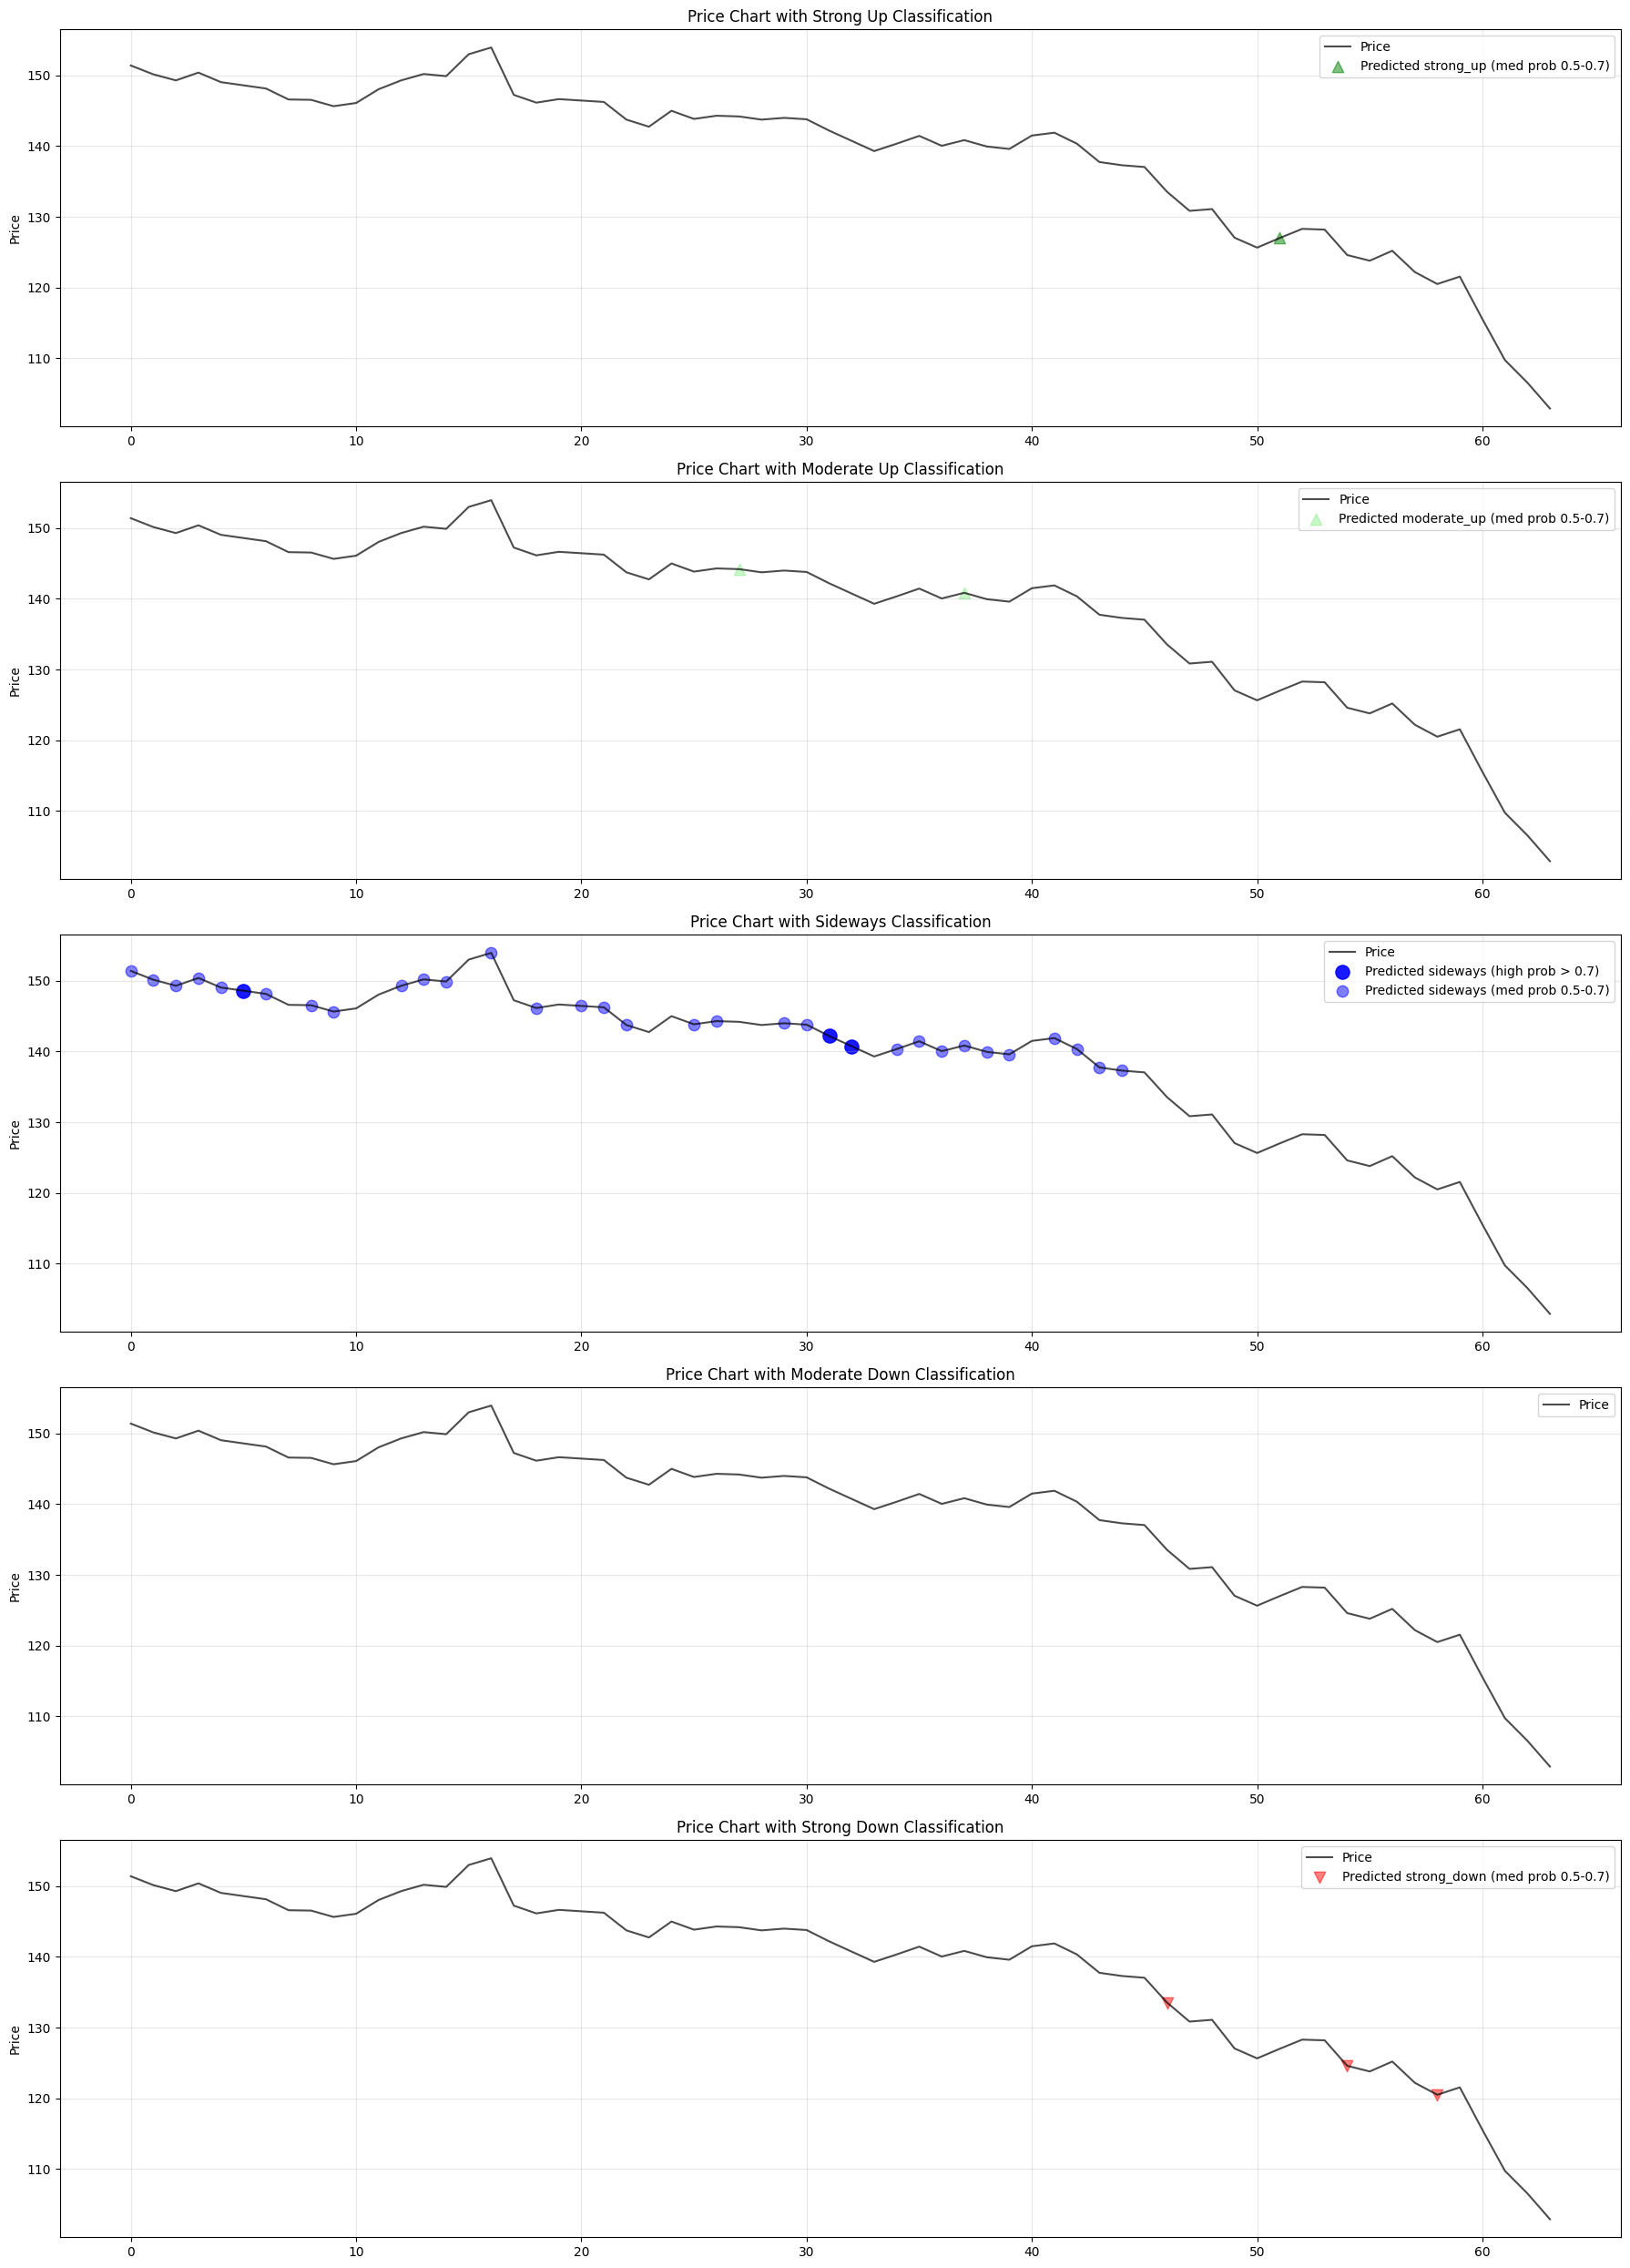

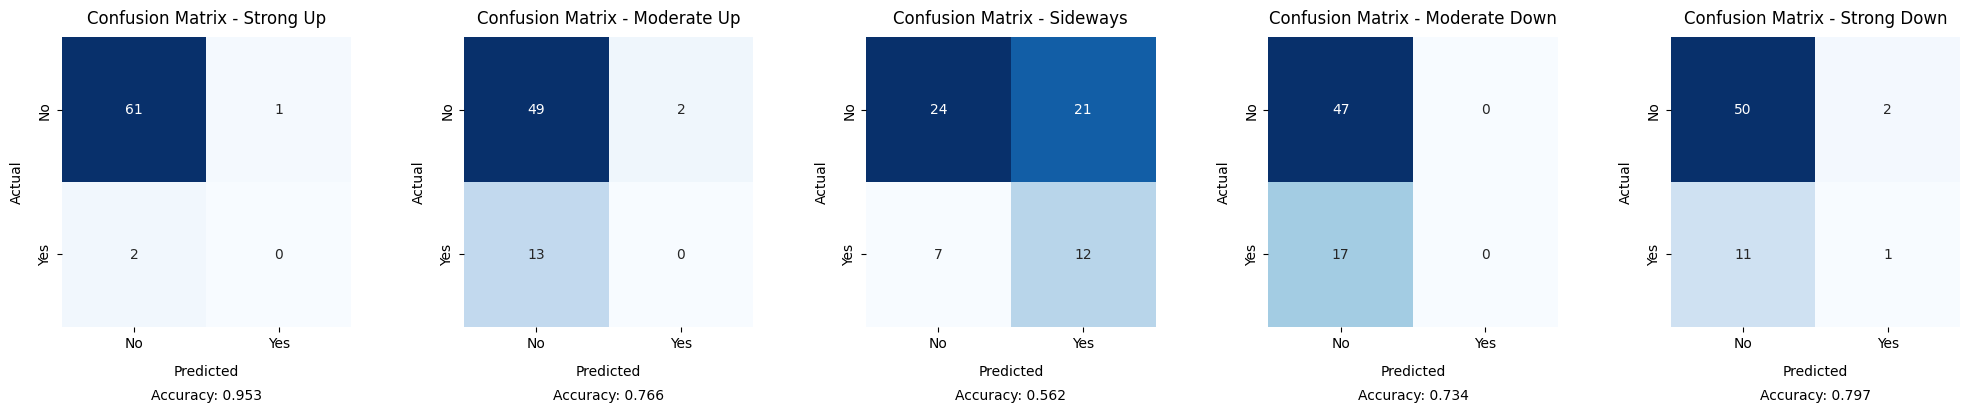

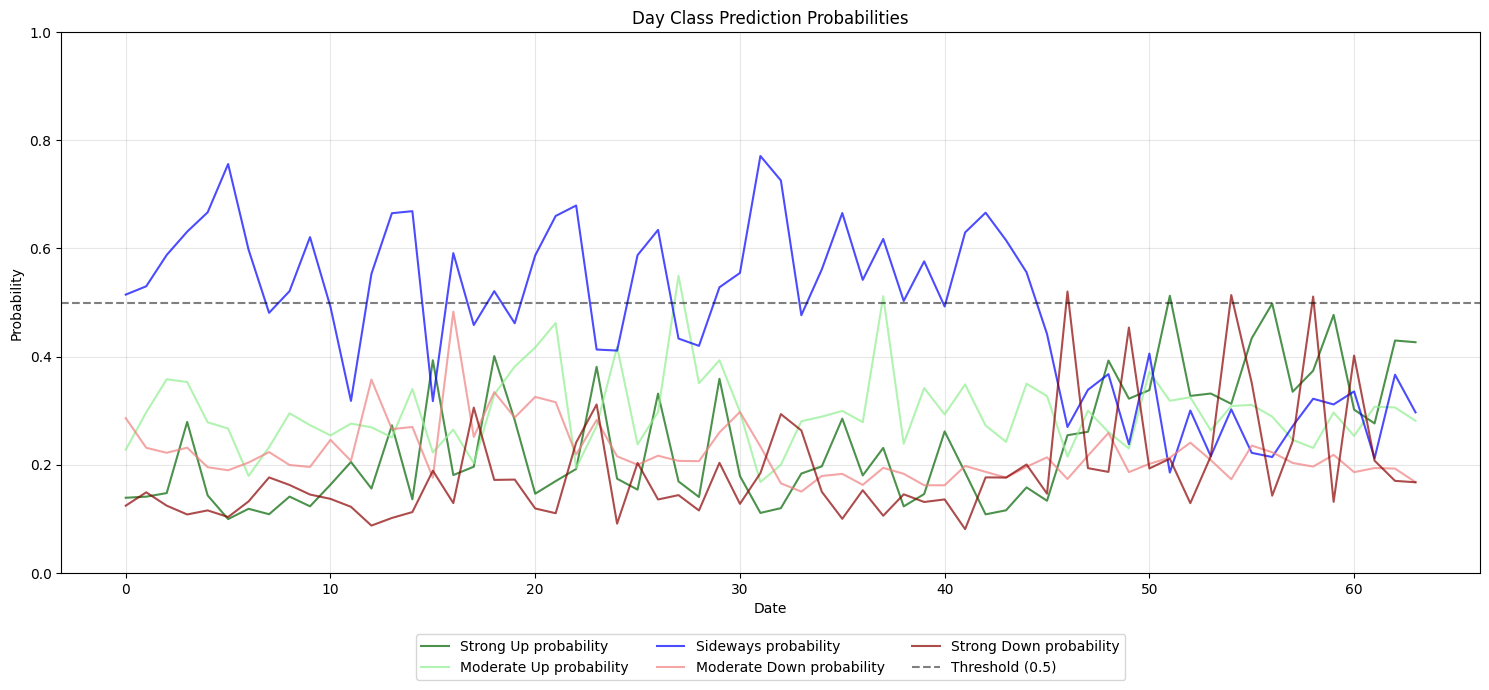

{'models': {'scaler': StandardScaler(),
  'next_day_strong_up': {'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=0.8, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.1, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=5, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=100, n_jobs=None,
                 num_parallel_tree=None, random_state=42, ...),
   'rf': RandomForestClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=4,
                          min_samples_split=10, random_st

In [ ]:
run_day_classification(df_train, df_test)

In [ ]:
df1=cmc_data.copy()
#chọn cột Date, high, low, volumn
df1=df1[['Date','High_CMC','Low_CMC','Volume_CMC']]
df1

,Date,High_CMC,Low_CMC,Volume_CMC
0,2017-08-24,6.46,6.23,9220
1,2017-08-25,6.37,6.16,9210
2,2017-08-28,6.31,6.12,35370
3,2017-08-29,6.31,6.12,12940
4,2017-08-30,6.39,6.31,43600
...,...,...,...,...
1900,2025-04-02,38.90,38.10,332200
1901,2025-04-03,37.80,35.80,903700
1902,2025-04-04,33.80,33.30,1840500
1903,2025-04-08,31.70,31.00,541200


In [ ]:

df1.rename(columns={'Date':'time','High_CMC':'high','Low_CMC':'low','Volume_CMC':'volume'},inplace=True)
df1['time']=pd.to_datetime(df1['time'])
df1_train = df1[df1['time'].dt.year < 2025]
df1_test = df1[df1['time'].dt.year >= 2025]

Running day classification workflow...
Preprocessing data...
Preprocessed data shapes: Train=(1631, 130), Test=(64, 130)
Classifying market days...
Preparing features for classification...
Feature shapes: X_train=(1631, 195), X_test=(64, 195)
Training day classifiers...
Training classifier for next_day_strong_up...
  Class distribution: {0.0: 1301, 1.0: 330}
Training classifier for next_day_moderate_up...
  Class distribution: {0.0: 1362, 1.0: 269}
Training classifier for next_day_sideways...
  Class distribution: {0.0: 1197, 1.0: 434}
Training classifier for next_day_moderate_down...
  Class distribution: {0.0: 1331, 1.0: 300}
Training classifier for next_day_strong_down...
  Class distribution: {0.0: 1334, 1.0: 297}
Training classifier for next_day_trend...
  Class distribution: {0.0: 1290, 1.0: 341}
Training classifier for next_day_reversal...
  Class distribution: {0.0: 848, 1.0: 783}
Training classifier for next_day_high_volatility...
  Class distribution: {0.0: 1223, 1.0: 408}
Ma

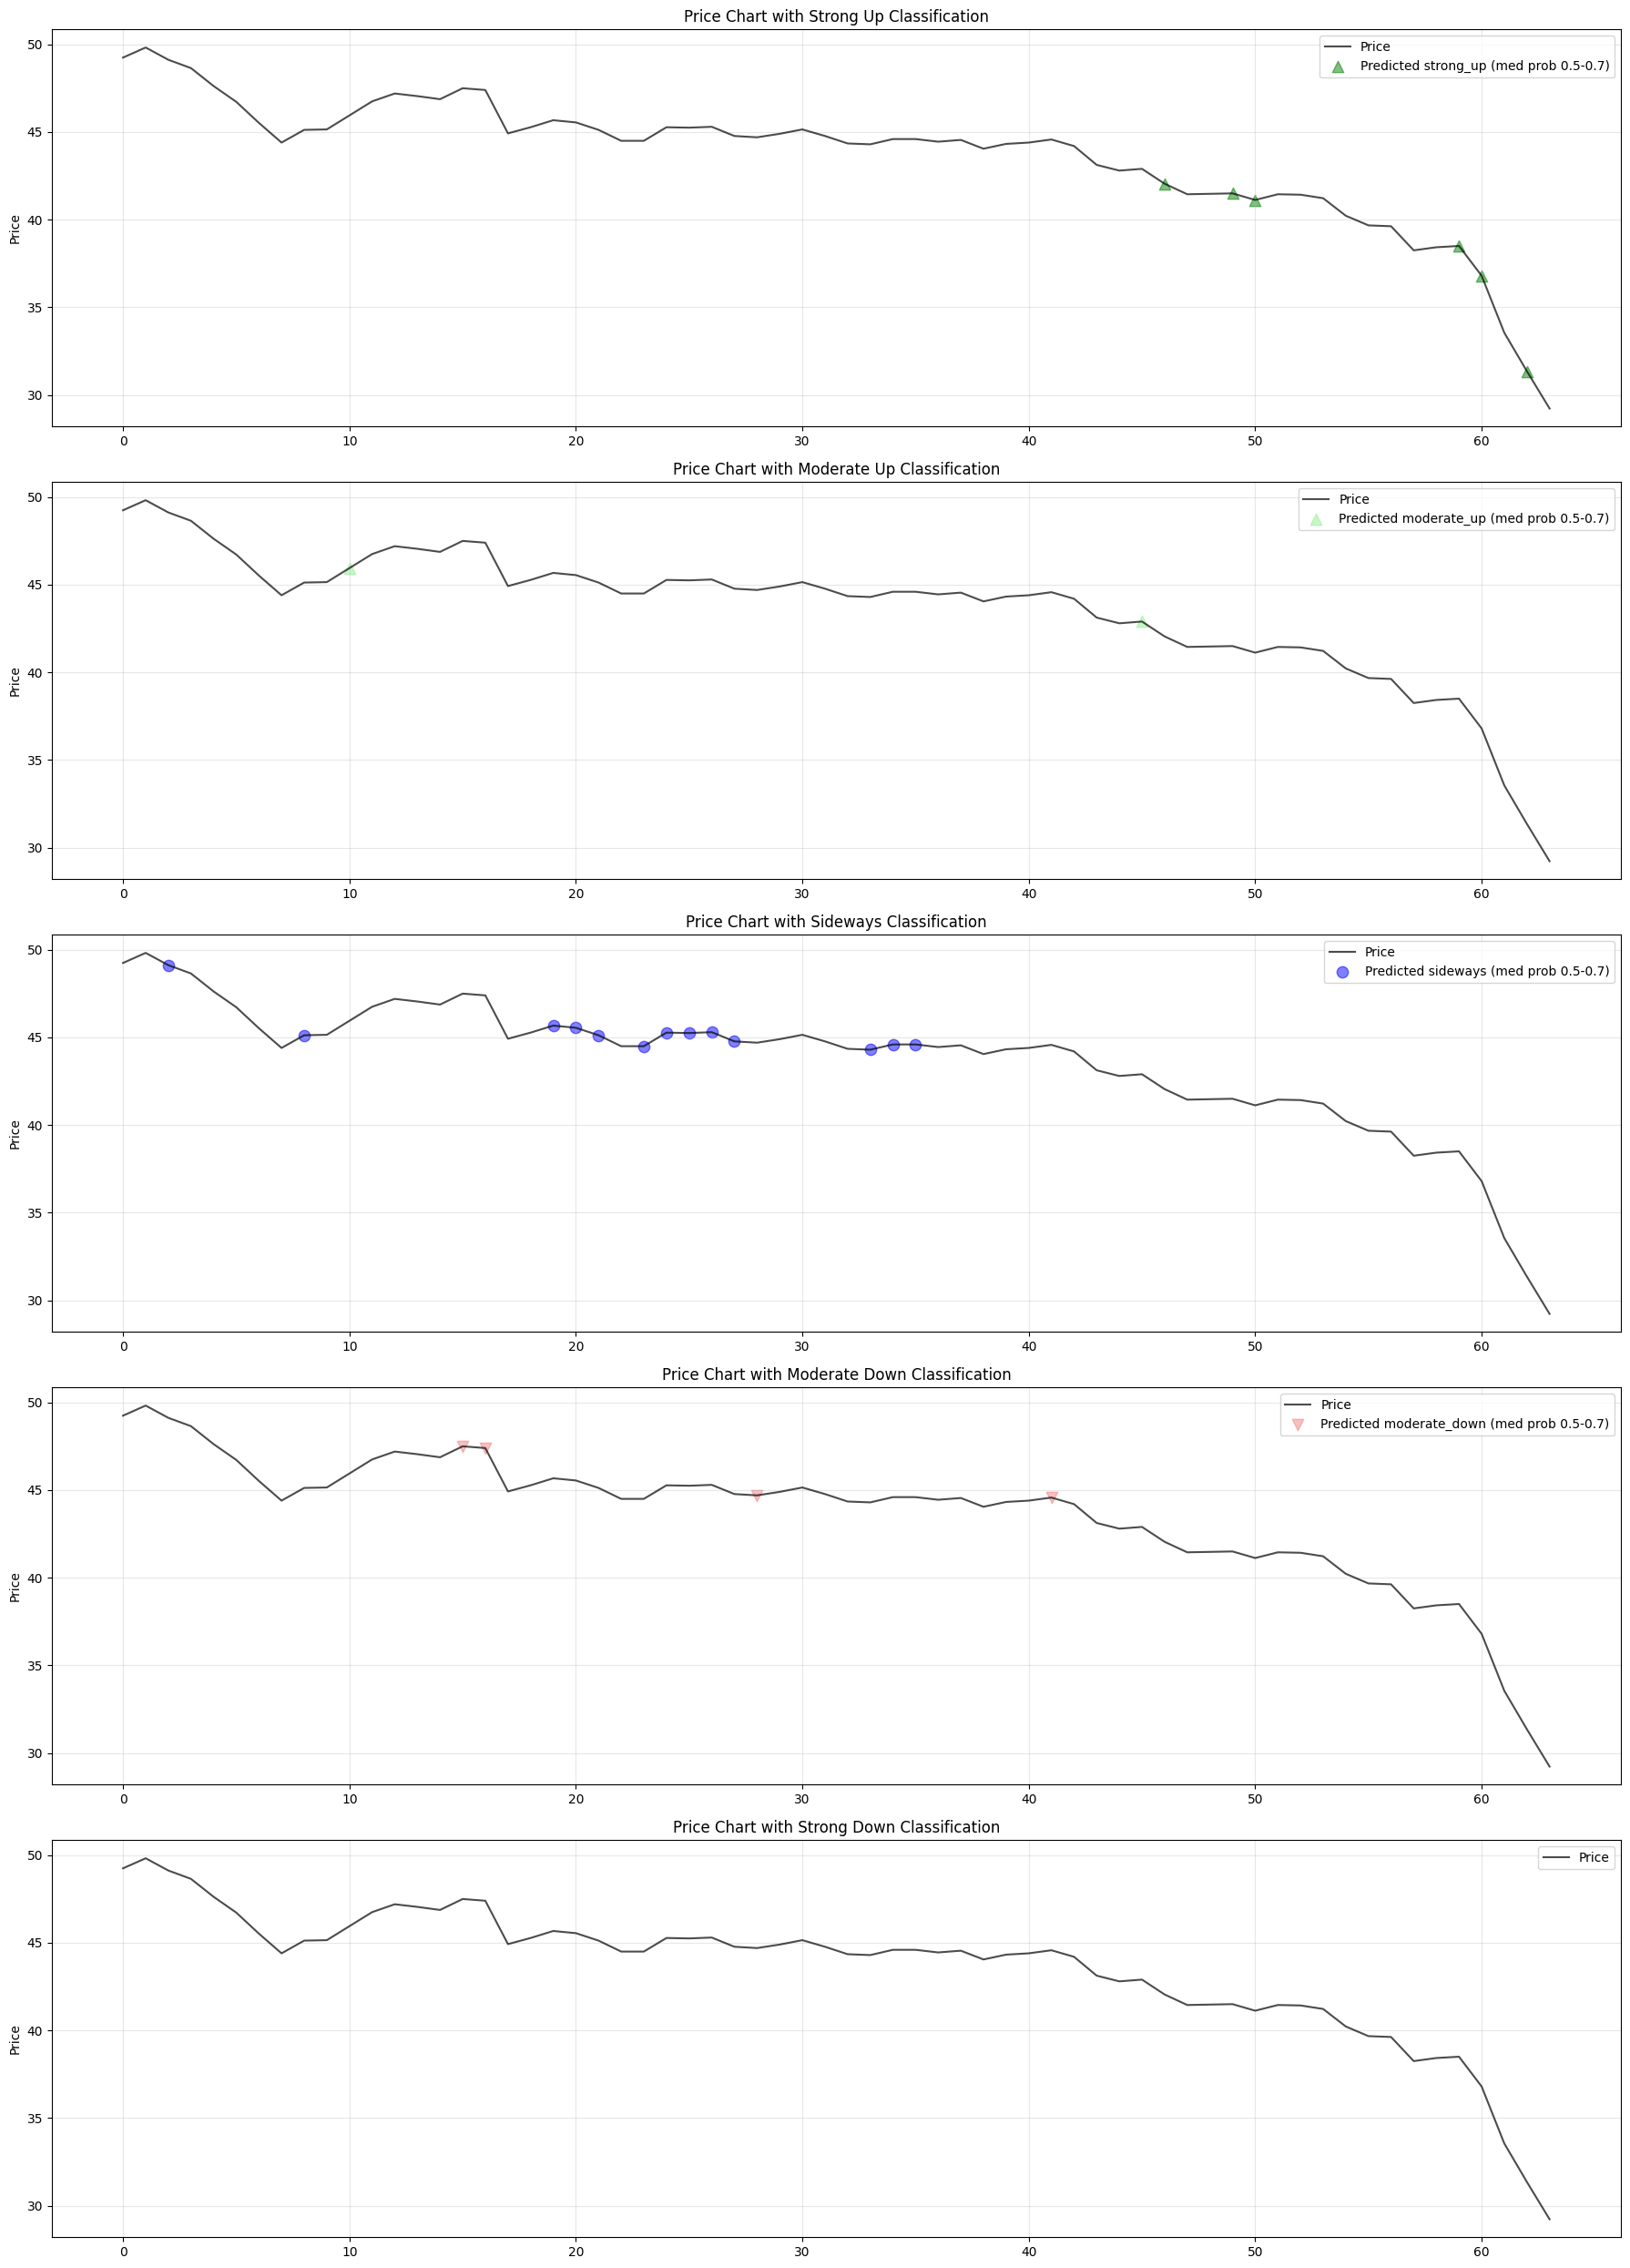

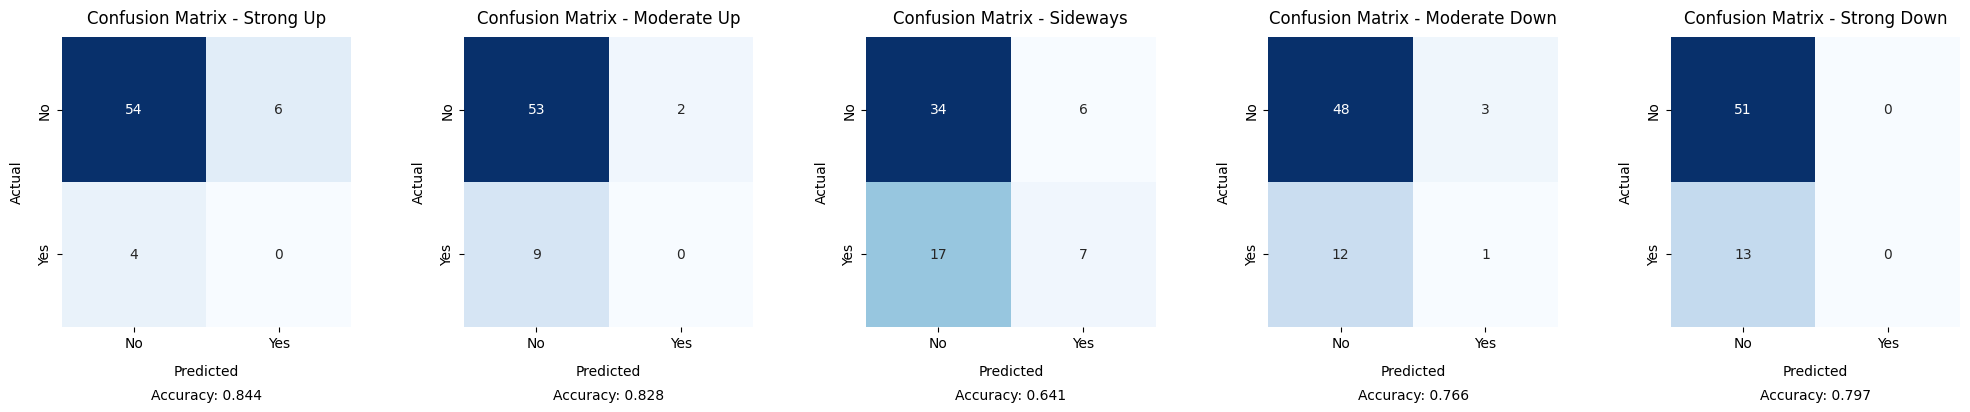

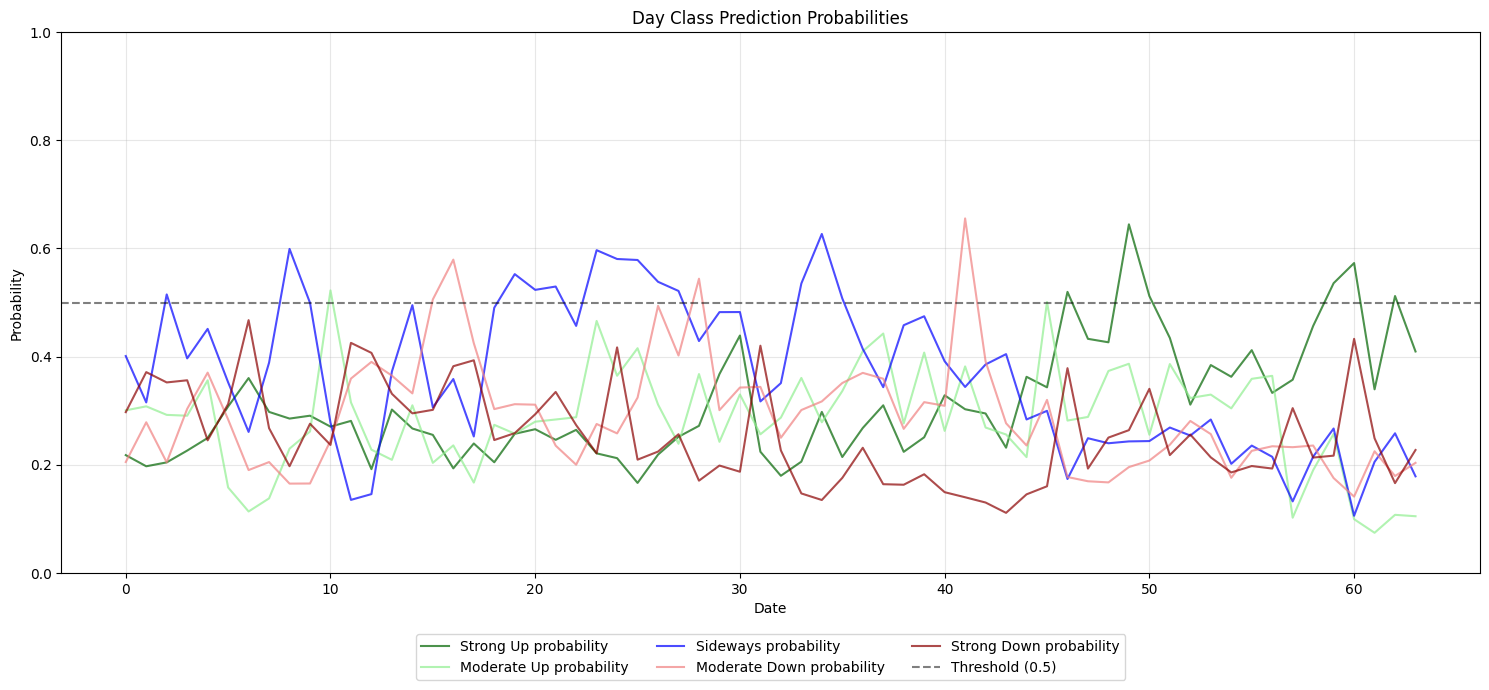

{'models': {'scaler': StandardScaler(),
  'next_day_strong_up': {'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=0.8, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.1, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=5, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=100, n_jobs=None,
                 num_parallel_tree=None, random_state=42, ...),
   'rf': RandomForestClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=4,
                          min_samples_split=10, random_st

In [ ]:
run_day_classification(df1_train, df1_test)